In [1]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("../")
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg
from Data import Data_eval
import Data
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm
import seaborn as sns
from sklearn.inspection import permutation_importance
import itertools

import matplotlib_functions as mympf

pd.set_option("display.float_format", lambda x: "%.1f" % x)

mympf.setMatplotlibParam(target="paper")
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/weights"
dir_plots = "paper-inv"

dir_res_lip = os.path.join(dir_res, "lip")
dir_res_box = os.path.join(dir_res, "box")
dir_res_tur = os.path.join(dir_res, "tur")

Matplotlib is building the font cache; this may take a moment.
2023-11-09 13:46:06.222155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 13:46:06.222558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 13:46:06.258628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 13:46:09.130418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropr

<Figure size 1920x1440 with 0 Axes>

# Dataset: fields description

In [4]:
path_ds = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
ds = xr.open_dataset(path_ds)

In [5]:
mympf.setMatplotlibParam_singlefig(target="paper")
plt.viridis()

<Figure size 1200x900 with 0 Axes>

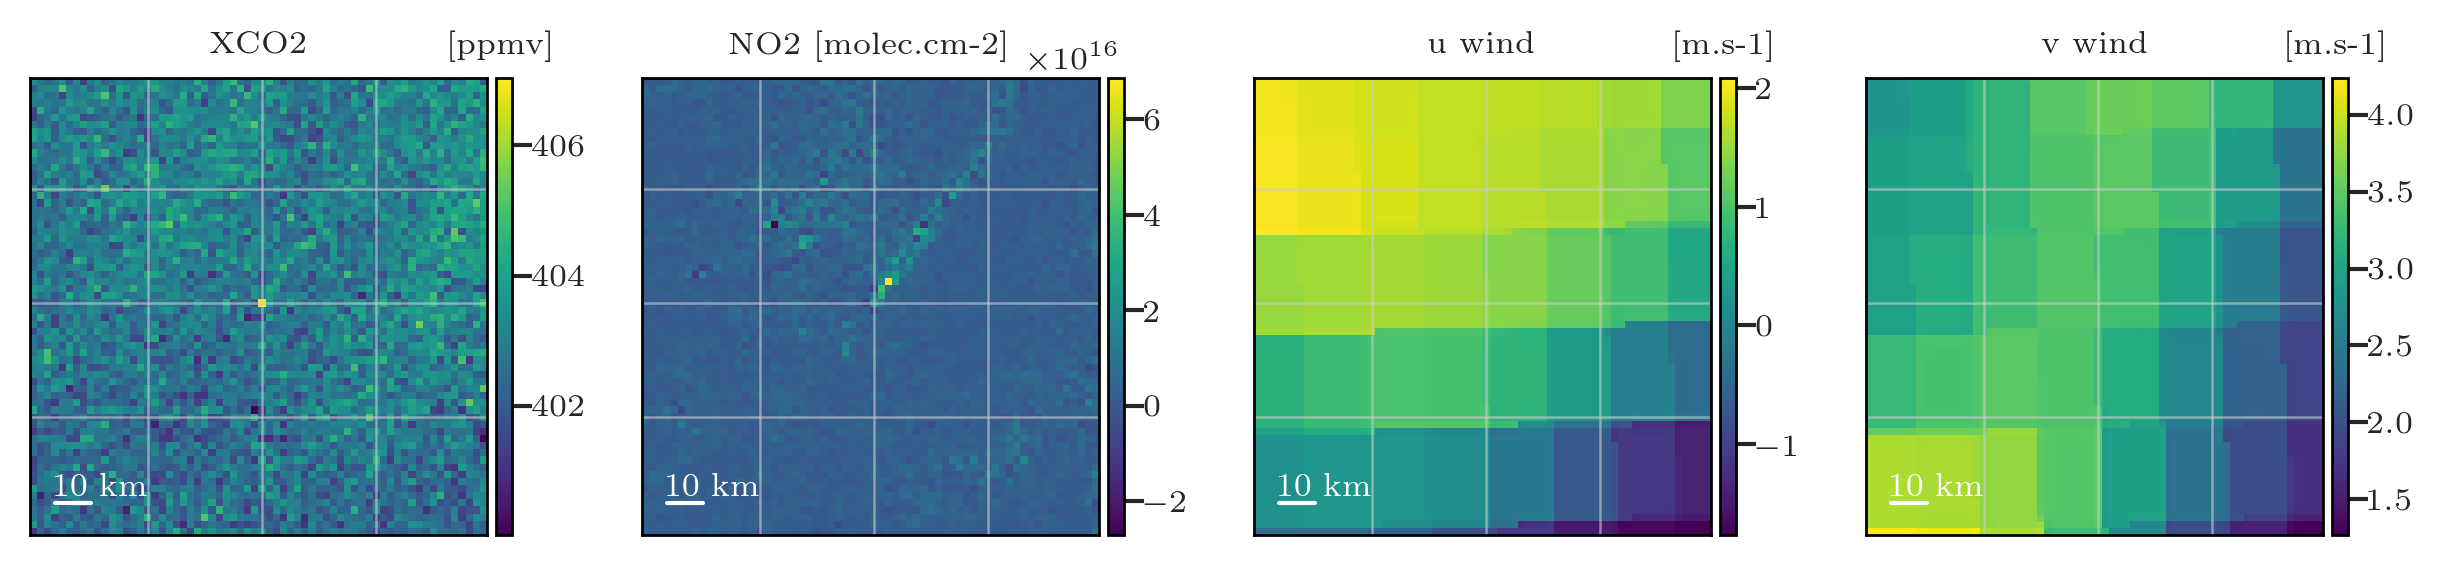

In [12]:
idx = 727
axs = mympf.set_figure_axs(
    1,
    4,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.01,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)


im = axs[0].imshow(np.squeeze(ds.xco2_noisy[idx, :, :]), origin="lower")
cax = axs[0].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[ppmv]")
axs[0].set_title("XCO2")


im = axs[1].imshow(np.squeeze(ds.no2_noisy[idx, :, :]), origin="lower")
cax = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
axs[1].set_title("NO2 [molec.cm-2]")


u_wind = ds.u
im = axs[2].imshow(np.squeeze(u_wind[idx, :, :]), origin="lower")
cax = axs[2].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
axs[2].set_title("u wind")


v_wind = ds.v
im = axs[3].imshow(np.squeeze(v_wind[idx, :, :]), origin="lower")
cax = axs[3].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
axs[3].set_title("v wind")

Ny = 64
Nx = 64
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    scale_bar_length = 5  # in image units
    scale_bar_pixel_length = 1  # length of the scale bar in pixels
    scale_bar_color = "white"
    ax.plot(
        [3, 3 + scale_bar_length],
        [4, 4],
        color=scale_bar_color,
        linewidth=scale_bar_pixel_length,
    )
    ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "data_inputs_lip_example.pdf"), transparent=True)

# Segmentation

In [14]:
# Turow
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/res/segmentation/seg_tur"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"

In [15]:
data = model_eval.get_data_for_segmentation(
    name_model,
    path_eval_nc,
)

model = model_eval.get_segmentation_model(name_model, name_w="w_best.h5")

data.y.train.shape (6289, 64, 64, 1)


2023-09-25 10:43:02.032869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 10:43:02.603595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14708 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [16]:
wbce = model_eval.get_wbce_model_on_data(model, data)
print(np.mean(wbce))
nwbce = model_eval.get_nwbce_model_on_data(model, data)
print(np.mean(nwbce))

2023-09-25 10:43:04.981912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-25 10:43:05.600704: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 7s 9ms/step
0.14063002
197/197 [==============================] - 1s 7ms/step
0.55647933


In [17]:
data.x.eval[idx, :, :, -1].mean()

2069264253895168.5

nwbce: 0.2936491072177887
idx: 77
origin: smart_2km_Tur_64
time: 2015-01-08T05:00:00.000000000
emiss: [9.033682 8.016872 8.129713]

nwbce: 0.4781067669391632
idx: 1556
origin: smart_2km_Tur_64
time: 2015-03-30T20:00:00.000000000
emiss: [ 9.840071 10.03323  10.61207 ]

nwbce: 0.3605290949344635
idx: 5359
origin: smart_2km_Tur_64
time: 2015-10-31T07:00:00.000000000
emiss: [8.391708 6.216371 5.516638]



<Figure size 1200x900 with 0 Axes>

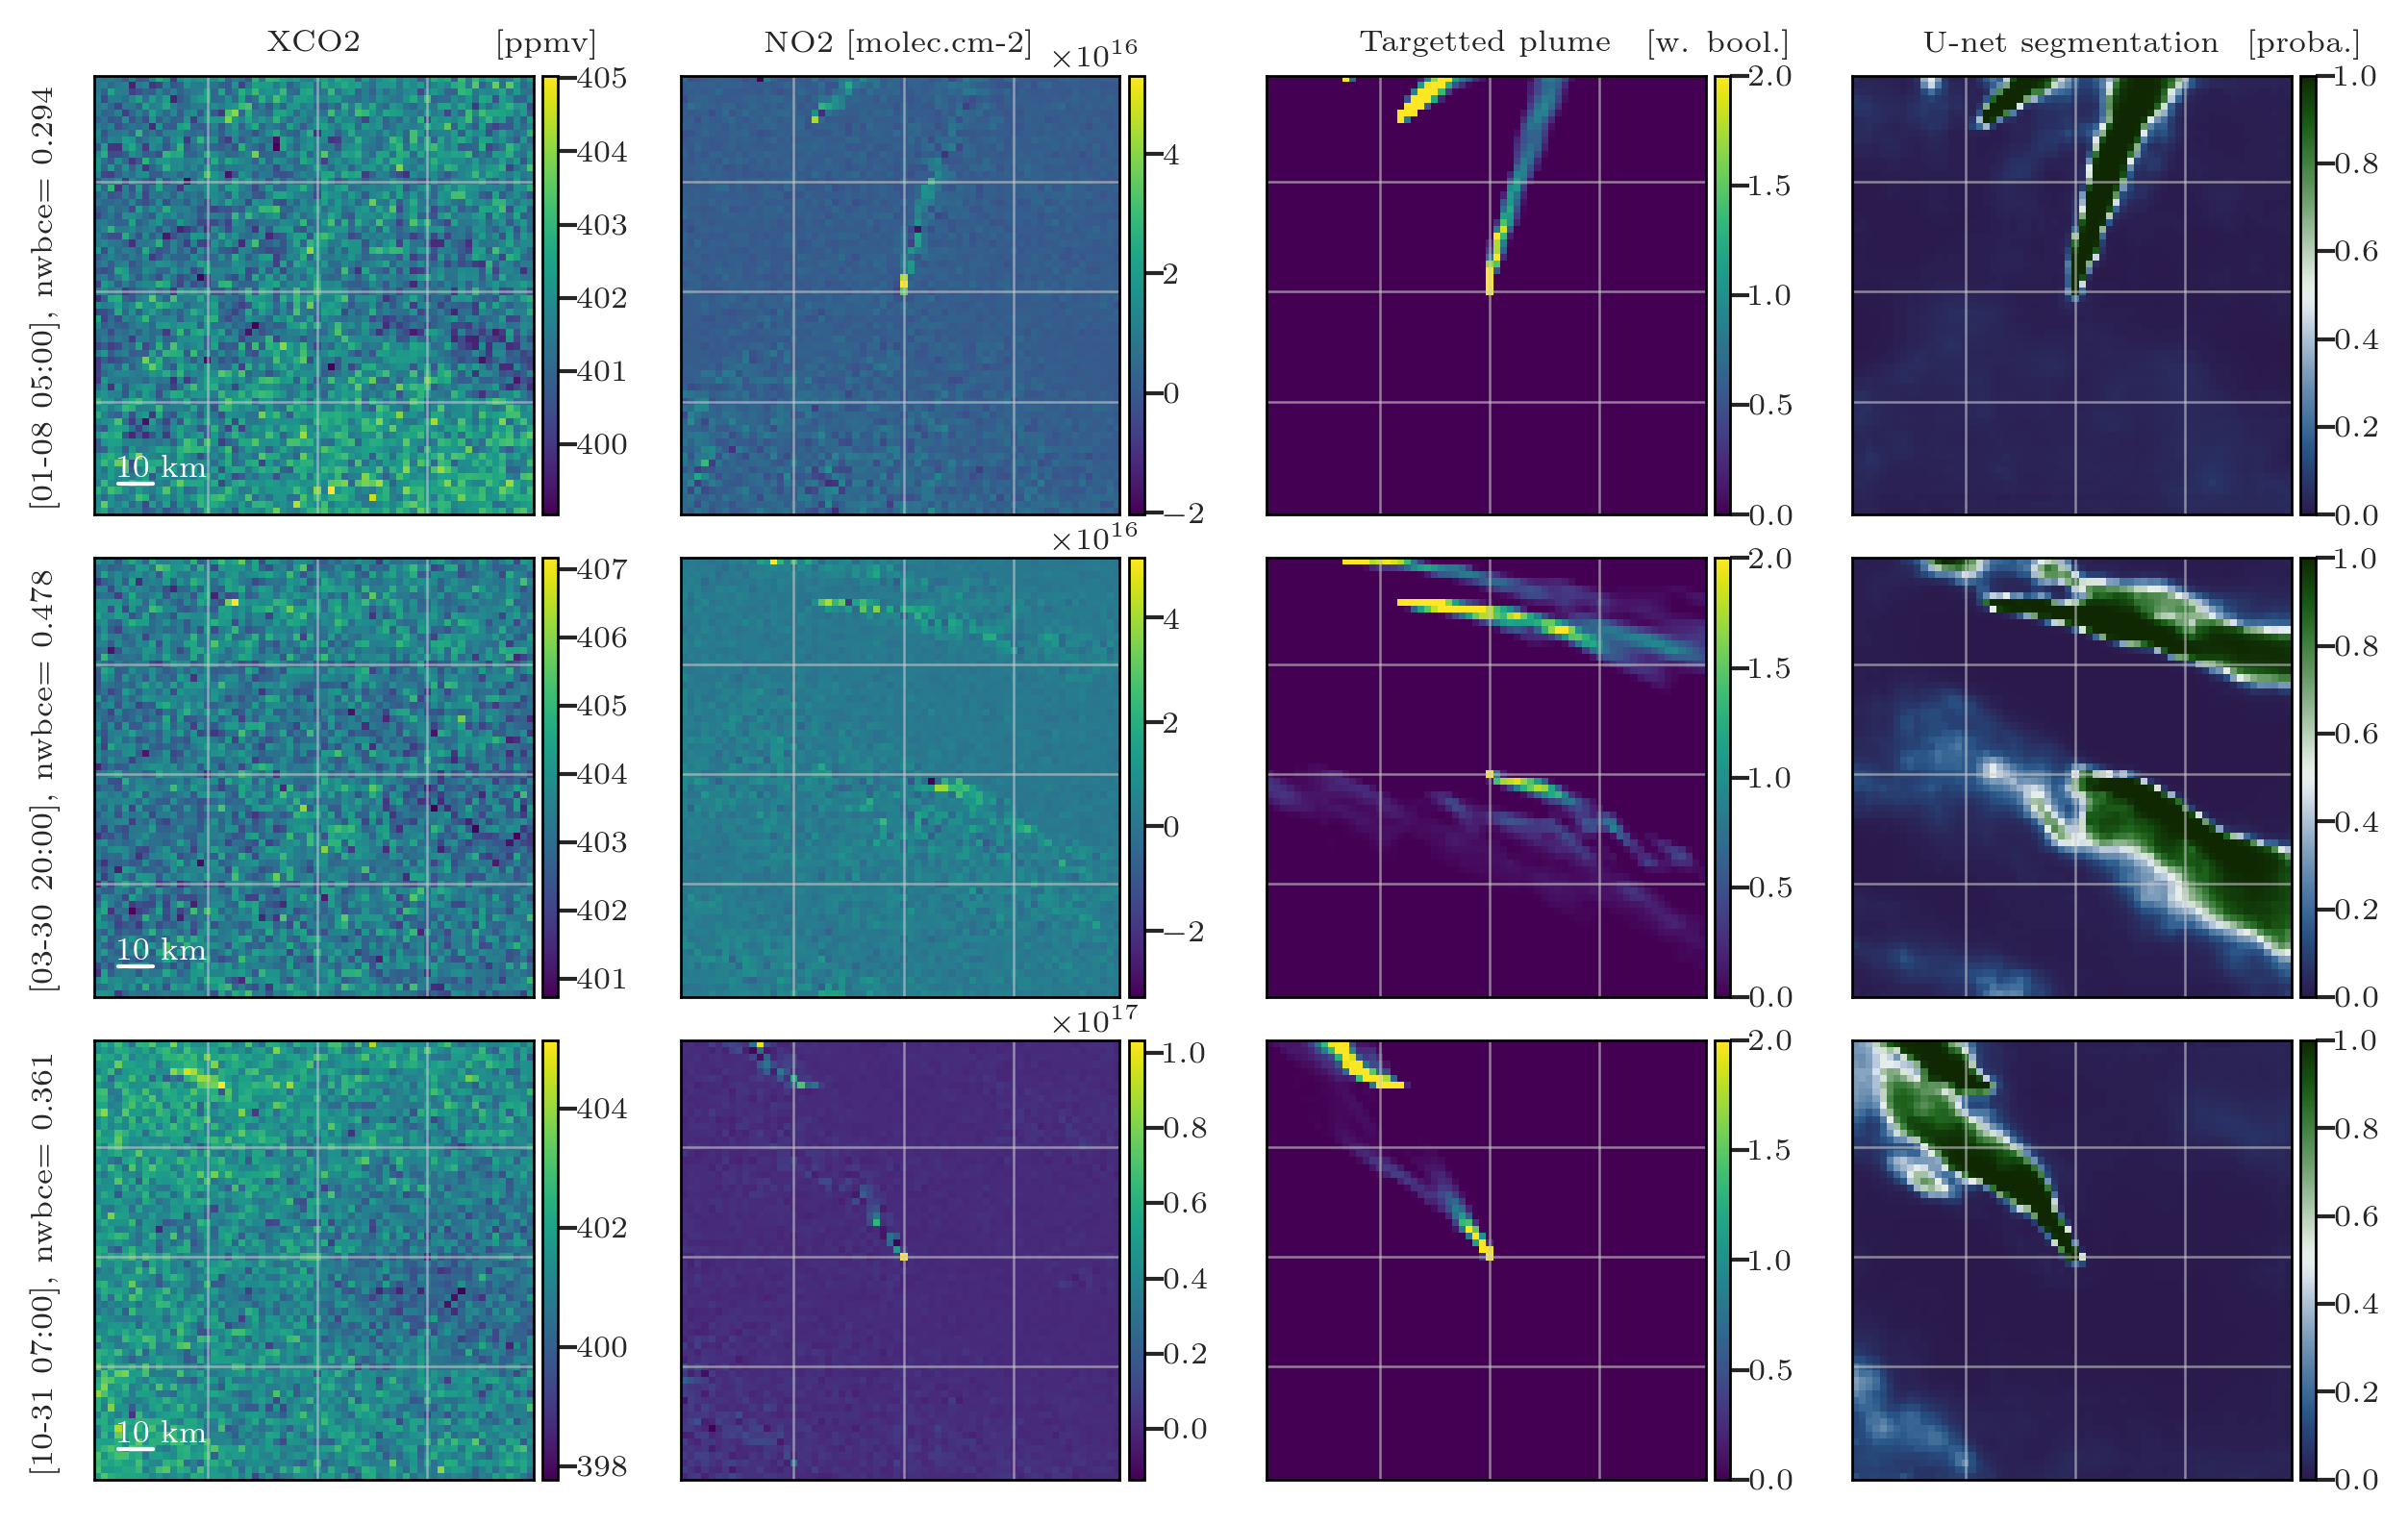

In [20]:
[idx0, ds_idx0] = model_eval.draw_idx(nwbce, data.ds, interval=[0.125, 0.375], idx=77)
[idx1, ds_idx1] = model_eval.draw_idx(nwbce, data.ds, interval=[0.375, 0.625], idx=1556)
[idx2, ds_idx2] = model_eval.draw_idx(nwbce, data.ds, interval=[0.625, 0.875], idx=5359)
list_idx = [idx0, idx1, idx2]
list_ds_idx = [ds_idx0, ds_idx1, ds_idx2]

N_idx = len(list_idx)

N_cols = 4

mympf.setMatplotlibParam(target="paper")
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.15,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for ax in [axs[0], axs[4], axs[8]]:
    scale_bar_length = 5  # in image units
    scale_bar_pixel_length = 1  # length of the scale bar in pixels
    scale_bar_color = "white"
    ax.plot(
        [3, 3 + scale_bar_length],
        [4, 4],
        color=scale_bar_color,
        linewidth=scale_bar_pixel_length,
    )
    ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

for i, idx in enumerate(list_idx):

    x_idx = data.x.eval[idx]

    cur_row = 0

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.eval[idx, :, :, -1]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.y.eval[idx]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(model(tf.expand_dims(data.x.eval[idx], 0))[0]),
        vmin=0,
        vmax=1,
        cmap=cm.cork,
        origin="lower",
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")


list_pd_t_idx = []
list_cnn_nwbce = []
for idx, ds_idx in enumerate(list_ds_idx):
    list_pd_t_idx.append(pd.Timestamp(ds_idx.time.values))
    list_cnn_nwbce.append(nwbce[list_idx[idx]])

for i, (pd_t_idx, loss_idx) in enumerate(
    zip(
        list_pd_t_idx,
        list_cnn_nwbce,
    )
):
    axs[i * N_cols].set_ylabel(
        f"[{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00], nwbce={loss_idx: .3f}"
    )

axs[0].set_title("XCO2")
axs[1].set_title("NO2 [molec.cm-2]")
axs[2].set_title("Targetted plume")
axs[3].set_title("U-net segmentation")

cbars[0].ax.set_title("[ppmv]")
cbars[2].ax.set_title("[w. bool.]")
cbars[3].ax.set_title("[proba.]")
plt.savefig(os.path.join(dir_plots, "seg_pred.pdf"), transparent=True)

#  Inversion: theory / Problem description

In [31]:
path_ds = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
ds = xr.open_dataset(path_ds)

In [32]:
mympf.setMatplotlibParam_singlefig(target="paper")
plt.viridis()

<Figure size 1200x900 with 0 Axes>

In [33]:
idx = 400

In [34]:
Ny = 64
Nx = 64

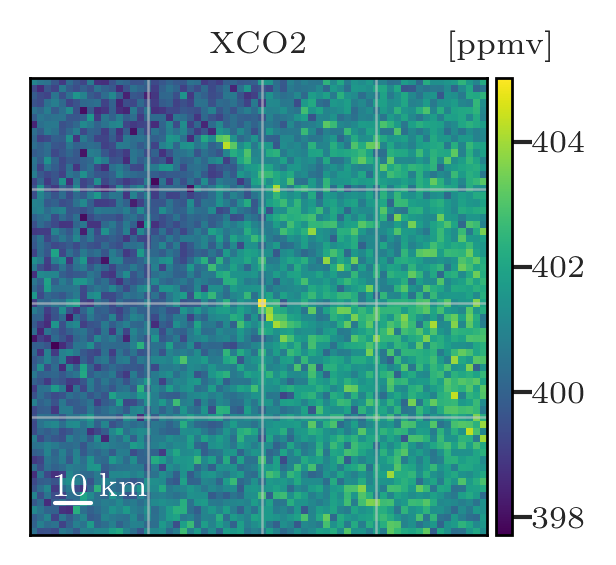

In [35]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.15,
    pad_h_ext=0.17,
    pad_h_int=0.15,
)
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(ds.xco2_noisy[idx, :, :]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("XCO2")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "box_xco2_input.png"), transparent=True)

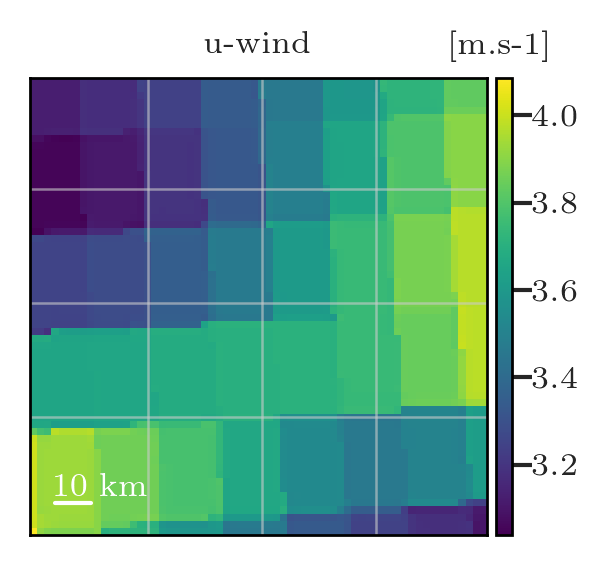

In [36]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.15,
    pad_h_ext=0.17,
    pad_h_int=0.15,
)
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(ds.u[idx, :, :]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("u-wind")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "box_uwind_input.png"), transparent=True)

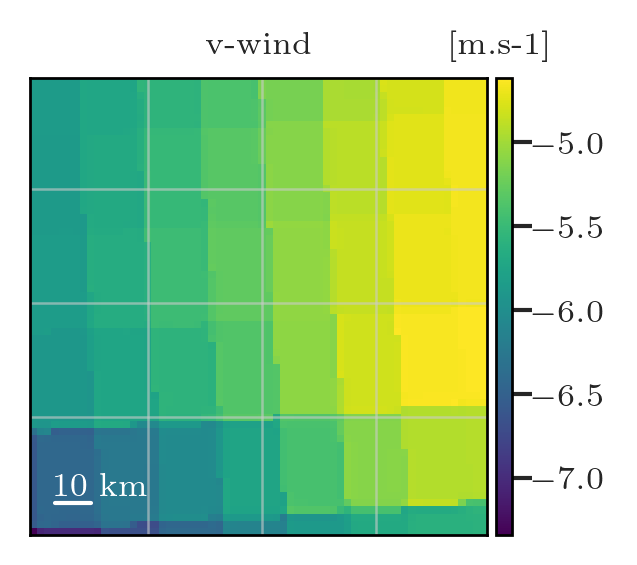

In [37]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.15,
    pad_h_ext=0.17,
    pad_h_int=0.15,
)
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(ds.v[idx, :, :]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[m.s-1]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("v-wind")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "box_vwind_input.png"), transparent=True)

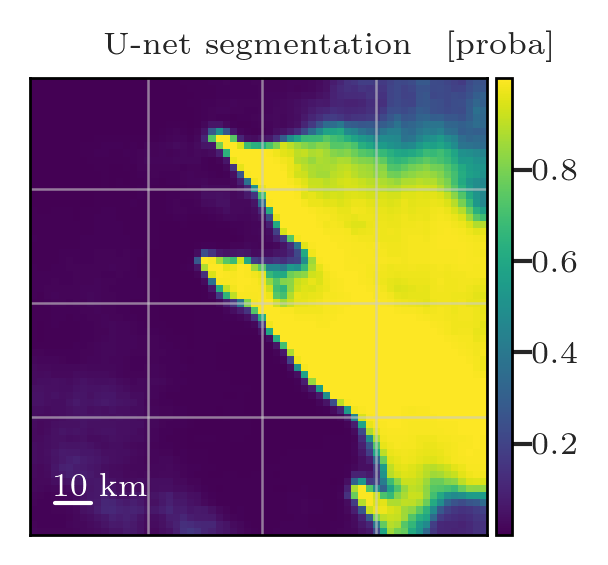

In [38]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.15,
    pad_h_ext=0.17,
    pad_h_int=0.15,
)

i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(ds.seg_pred_no2[idx, :, :]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
cbar.ax.set_title("[proba]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("U-net segmentation")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)
plt.savefig(os.path.join(dir_plots, "box_seg_input.png"), transparent=True)

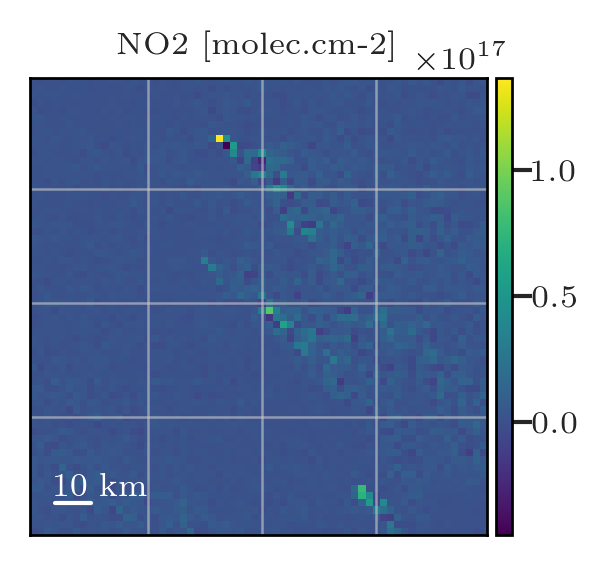

In [39]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.15,
    pad_h_ext=0.17,
    pad_h_int=0.15,
)

i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(ds.no2_noisy[idx, :, :]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("NO2 [molec.cm-2]")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)
plt.savefig(os.path.join(dir_plots, "box_no2_input.png"), transparent=True)

# Inversion: theory / Preprocessing layers

In [40]:
path_ds = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
ds = xr.open_dataset(path_ds)

In [41]:
ds

<xarray.Dataset>
Dimensions:          (idx_img: 6289, y: 64, x: 64, hour_prec: 3)
Coordinates:
  * idx_img          (idx_img) int32 0 1 2 3 4 5 ... 6284 6285 6286 6287 6288
  * y                (y) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * x                (x) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
Dimensions without coordinates: hour_prec
Data variables: (12/21)
    point_source     (idx_img) object ...
    time             (idx_img) datetime64[ns] ...
    xco2             (idx_img, y, x) float32 ...
    xco2_back        (idx_img, y, x) float32 ...
    xco2_alt_anthro  (idx_img, y, x) float32 ...
    no2              (idx_img, y, x) float32 ...
    ...               ...
    bool_perf_seg    (idx_img, y, x) float32 ...
    w_perf_seg       (idx_img, y, x) float32 ...
    psurf            (idx_img, y, x) float32 ...
    clct             (idx_img, y, x) float32 ...
    v_hour           (idx_img) int64 ...
    seg_pred_no2     (idx_img, x, y) float32 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_img:        6289

In [32]:
idx = 700

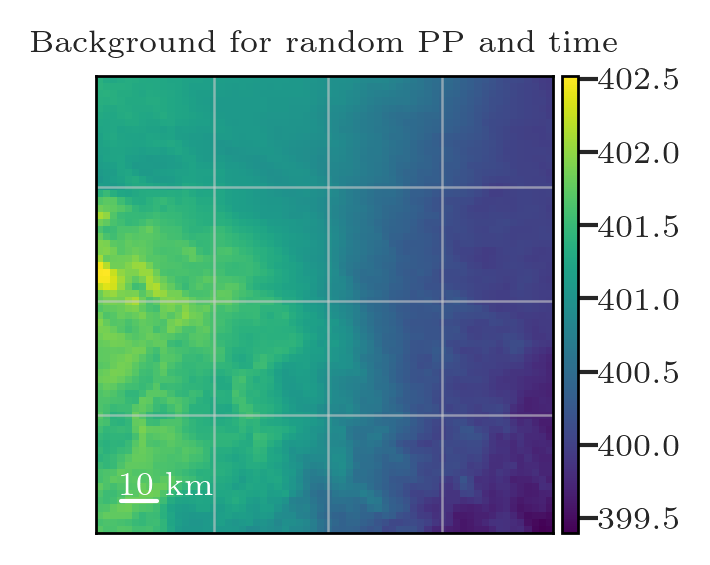

In [42]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.xco2_back.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Background for random PP and time")
scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "lip_background.png"), transparent=True)

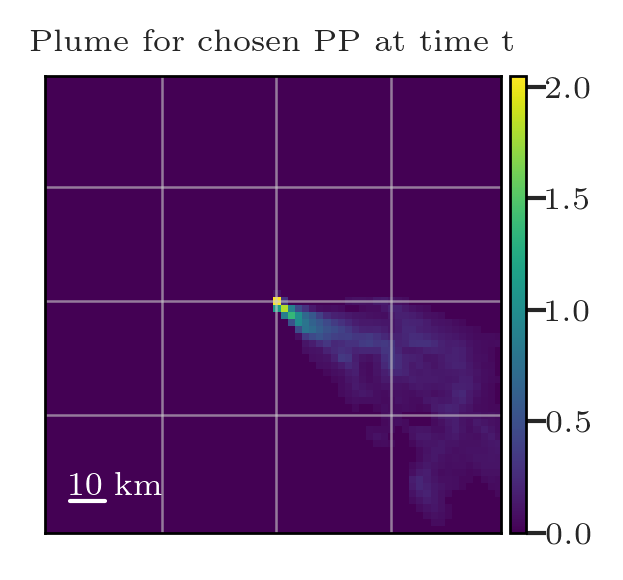

In [43]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.plume.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Plume for chosen PP at time t")

scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)

plt.savefig(os.path.join(dir_plots, "lip_plume.png"), transparent=True)

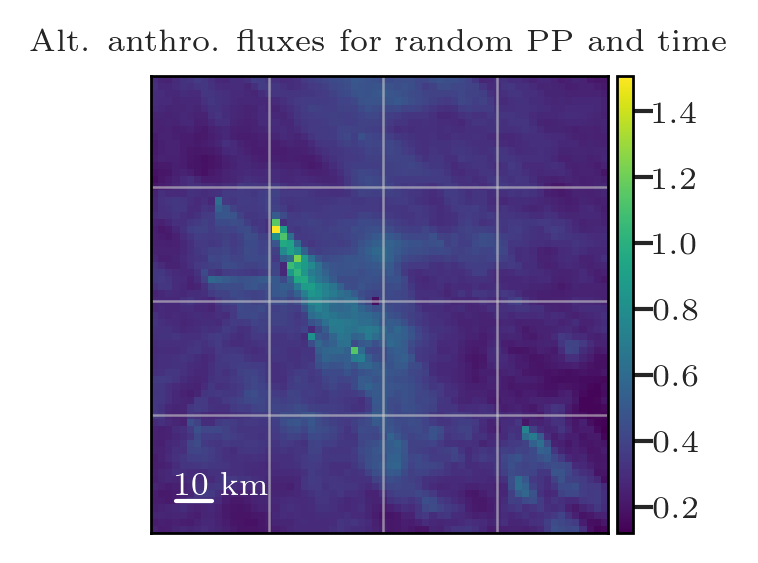

In [44]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.08,
    pad_w_ext_right=0.18,
    pad_w_int=0.2,
    pad_h_ext=0.18,
    pad_h_int=0.25,
)
Ny = int(len(ds.y))
Nx = int(len(ds.x))
i_ax = 0
ax = axs[i_ax]
data_plot = ds.xco2_alt_anthro.values[idx]
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
# cbar.ax.set_title("[ppmv]")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Alt. anthro. fluxes for random PP and time")
scale_bar_length = 5  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [3, 3 + scale_bar_length],
    [4, 4],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(3, 5, f"10 km", color=scale_bar_color, fontsize=8)
plt.savefig(os.path.join(dir_plots, "lip_alt_anthro.png"), transparent=True)

# Lippendorf

In [3]:
path_eval_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_lip = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"

In [4]:
all_dir_lip = []
for root, dirs, files in os.walk(dir_res_lip):
    if "w_best.h5" in files:
        all_dir_lip.append(root)

### None

In [5]:
chan_3 = "None"
all_dirs_lip_none = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_none.append(dir)

In [6]:
res_lip_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_none, path_eval_lip
)

2023-09-21 14:19:35.362246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 14:19:35.987972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14709 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-09-21 14:19:38.660547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-21 14:19:39.410576: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 3s 6ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/5
MAE 4.518257 3.9898558
MAPE 29.469942 27.213675
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/4
MAE 5.0572205 4.6081905
MAPE 32.77536 31.508839
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3_bis
MAE 3.9047232 3.3992567
MAPE 26.131603 23.21601
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/3
MAE 3.8428757 3.2866592
MAPE 25.870762 22.49356
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/best_none
MAE 3.522198 2.9706554
MAPE 23.75719 20.130203
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/2_bis
MAE 3.701279 3.1224794
MAPE 25.03127 21.047195
197/19

### no2

In [7]:
chan_3 = "no2"
all_dirs_lip_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_no2.append(dir)

In [8]:
res_lip_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_no2, path_eval_lip
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/11
MAE 3.4308136 2.8402615
MAPE 22.985023 19.339386
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/10
MAE 3.5528638 3.0123978
MAPE 23.558989 20.115795
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/7
MAE 3.6266482 3.102107
MAPE 24.0049 20.825886
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/best_no2
MAE 3.1278608 2.6126633
MAPE 21.701414 17.193655
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/6_bis
MAE 3.384119 2.8037844
MAPE 23.117825 18.926126
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/6
MAE 3.436228 2.8759108
MAPE 23.78897 19.266586

### seg_pred_no2

In [9]:
chan_3 = "seg_pred_no2"
all_dirs_lip_seg_pred_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_seg_pred_no2.append(dir)

In [10]:
res_lip_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_lip_seg_pred_no2, path_eval_lip
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/2
MAE 4.4649878 4.0360537
MAPE 28.900412 27.78929
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/1
MAE 4.3117757 3.8336697
MAPE 28.327154 26.059517
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/14
MAE 4.575145 4.0973387
MAPE 29.721245 27.783102
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/inv_lip_sweep/13
MAE 4.703371 4.204838
MAPE 30.436392 28.784525
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1
MAE 4.2319674 3.739544
MAPE 27.883333 25.823048
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/1_bis
MAE 4.2319674 3.739544
MAPE 27.883333 25.823048
19

### cross-sectional

In [159]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Lip", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [160]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
# y = np.concatenate((ds.emiss.values[0:1], ds.emiss.values[0:-1]))
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))
metrics_lip_cs = metrics_cs

images analysed: 0.9435522340594689
mae: 9.45554687078409 6.280673210008902
mape: 64.55498100584066 42.813141021105075


## Performance histograms

In [253]:
res_lip_none = model_eval.add_raw_inv_metrics(res_lip_none)
res_lip_seg_pred_no2 = model_eval.add_raw_inv_metrics(res_lip_seg_pred_no2)
res_lip_no2 = model_eval.add_raw_inv_metrics(res_lip_no2)

In [254]:
all_df_lip = model_eval.build_df_perf_inv(
    {
        "none": res_lip_none["metrics"],
        "seg_pred_no2": res_lip_seg_pred_no2["metrics"],
        "no2": res_lip_no2["metrics"],
        "cs": metrics_lip_cs,
    }
)

result_latex = all_df_lip["res"].rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [168]:
print(result_latex.to_latex())

\begin{tabular}{lrrrlrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{APE} & \multicolumn{3}{l}{AE} & \multicolumn{3}{l}{Relative error (\%)} & \multicolumn{3}{l}{Raw difference (Mt/yr)} \\
{} &  25\% &  50\% & \multicolumn{2}{l}{75\%} & 25\% & 50\% &  75\% &                25\% &  50\% &  75\% &                    25\% &  50\% &  75\% \\
Add. input:         &      &      &      &   &     &     &      &                    &      &      &                        &      &      \\
\midrule
No additional input & 10.0 & 21.6 & 35.4 &   & 1.5 & 3.2 &  5.2 &               -4.7 & -2.1 &  0.7 &                    8.9 & 12.1 & 15.2 \\
Segmentation        & 11.7 & 23.3 & 36.8 &   & 1.7 & 3.4 &  5.6 &               -5.2 & -2.7 & -0.0 &                    8.7 & 11.5 & 14.4 \\
NO2                 &  8.0 & 17.5 & 30.0 &   & 1.2 & 2.6 &  4.4 &               -3.3 & -0.7 &  1.8 &                   10.6 & 13.4 & 16.4 \\
CSF                 & 21.0 & 42.8 & 70.1 &   & 3.1 & 6.3 & 10.5 &               -7.1 & -2.6

/tmp/ipykernel_278872/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/lip_perf.pdf


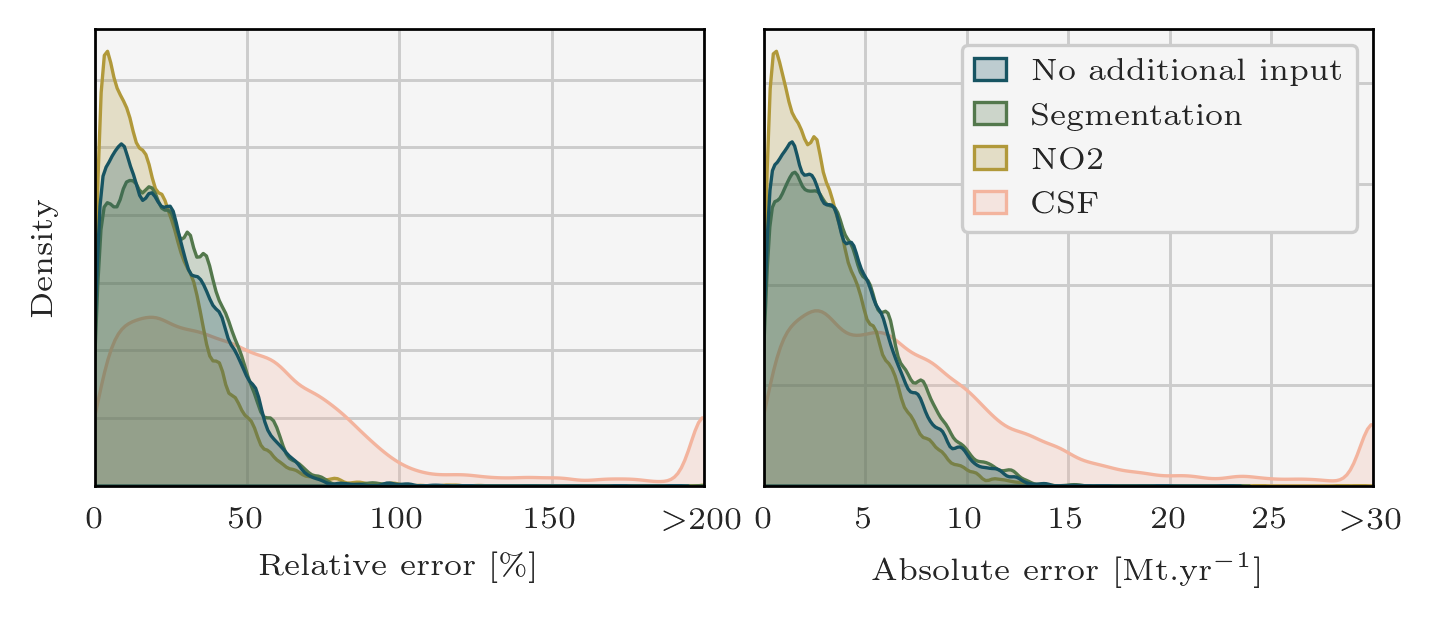

In [185]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    all_df_lip["df_mape"],
    x="Absolute relative error (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)
axs[i_ax].set_xlabel("Relative error [$\%$]")
axs[i_ax].set_xticks([0, 50, 100, 150, 200])
axs[i_ax].set_xticklabels(["0", "50", "100", "150", "$>$200"])

i_ax = 1
sns.kdeplot(
    all_df_lip["df_mae"],
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)
axs[i_ax].set_xlabel("Absolute error [Mt.yr$^{-1}$]")
axs[i_ax].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[i_ax].set_xticklabels(["0", "5", "10", "15", "20", "25", "$>$30"])

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"lip_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

<AxesSubplot: ylabel='Density'>

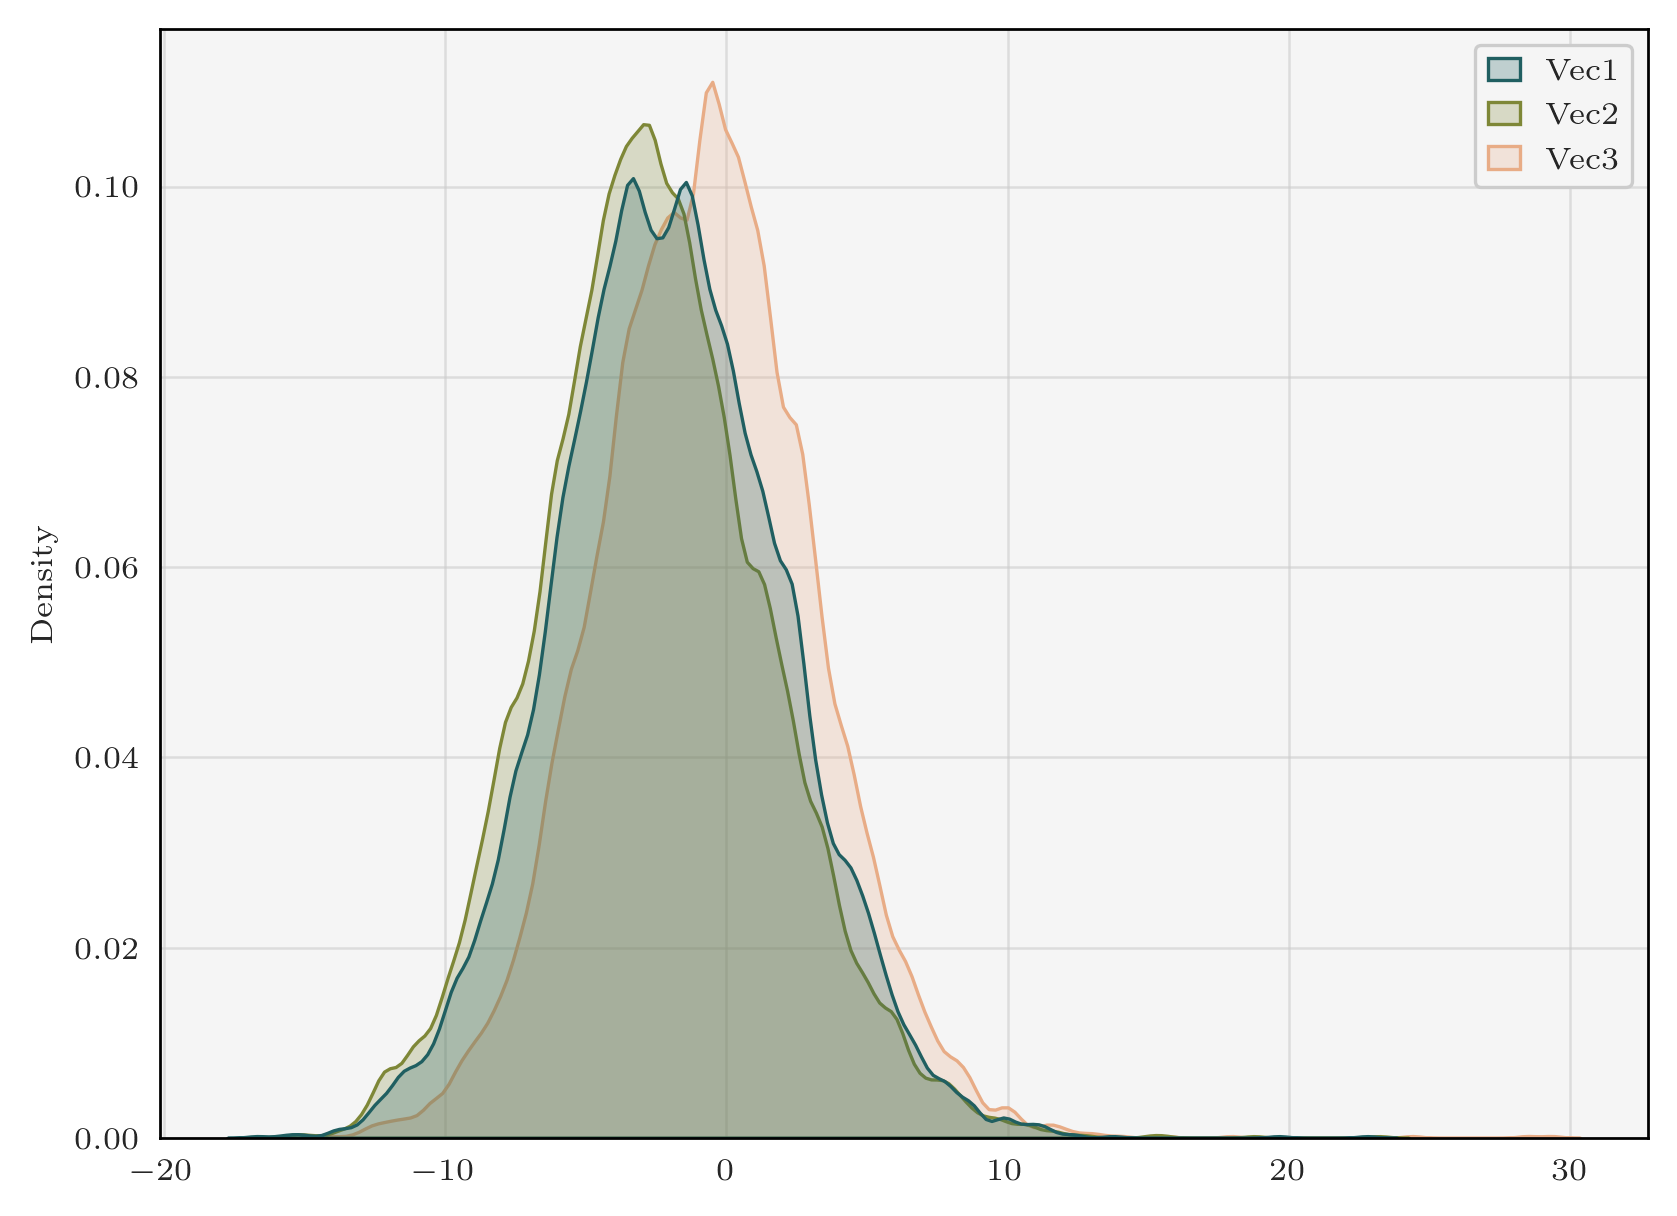

In [109]:
lip_none_diff = np.squeeze(res_lip_none["pred"]) - np.squeeze(
    res_lip_none["data"].y.eval
)
lip_seg_pred_no2_diff = np.squeeze(res_lip_seg_pred_no2["pred"]) - np.squeeze(
    res_lip_seg_pred_no2["data"].y.eval
)
lip_no2_diff = np.squeeze(res_lip_no2["pred"]) - np.squeeze(res_lip_no2["data"].y.eval)

df_lip_diff = pd.DataFrame(
    {"Vec1": lip_none_diff, "Vec2": lip_seg_pred_no2_diff, "Vec3": lip_no2_diff}
)

# Boxberg

In [17]:
path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_box = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "box")

In [18]:
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)

### None

In [19]:
chan_3 = "None"

In [20]:
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)

In [21]:
res_box_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_none, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/1
MAE 5.13549 4.605483
MAPE 26.950752 24.995522
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/2
MAE 5.3128967 4.75424
MAPE 27.85995 25.616583
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/0
MAE 4.995856 4.389345
MAPE 26.270487 23.396515
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_none
MAE 4.6566434 4.0240993
MAPE 24.67322 22.347471
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/3
MAE 5.4159718 4.864959
MAPE 28.704863 26.191845

Ensemble
MAE 4.908175 4.3461266
MAPE 25.818388 23.264322


### no2

In [22]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [23]:
res_box_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/5
MAE 6.8802795 6.6859875
MAPE 35.31896 36.52536
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_no2
MAE 5.965012 5.8093414
MAPE 30.780756 31.004927
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/8
MAE 8.512947 8.341297
MAPE 43.96034 45.347416
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/7
MAE 7.0972333 6.997657
MAPE 36.544006 37.6827
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/6
MAE 6.5846615 6.4743776
MAPE 33.81202 34.869263

Ensemble
MAE 6.946828 6.8537674
MAPE 35.71124 36.844368


### seg_pred_no2

In [24]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [25]:
res_box_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/12
MAE 7.2485166 7.158576
MAPE 37.579018 38.963028
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/best_seg_pred_no2
MAE 6.422189 6.3203106
MAPE 33.53212 34.019844
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box/11
MAE 7.2239275 7.1910906
MAPE 37.626534 38.961372

Ensemble
MAE 6.891569 6.824552
MAPE 35.829266 36.970592


### cross-sectional

In [169]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Box", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [170]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))

metrics_box_cs = metrics_cs

images analysed: 0.8495786293528383
mae: 9.727348490085312 7.730007449884406
mape: 52.86260729526279 41.52475536655409


## Performance histograms

In [258]:
res_box_none = model_eval.add_raw_inv_metrics(res_box_none)
res_box_seg_pred_no2 = model_eval.add_raw_inv_metrics(res_box_seg_pred_no2)
res_box_no2 = model_eval.add_raw_inv_metrics(res_box_no2)

In [259]:
all_df_box = model_eval.build_df_perf_inv(
    {
        "none": res_box_none["metrics"],
        "seg_pred_no2": res_box_seg_pred_no2["metrics"],
        "no2": res_box_no2["metrics"],
        "cs": metrics_box_cs,
    }
)
result_latex = all_df_box["res"].rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [173]:
print(result_latex.to_latex())

\begin{tabular}{lrrrlrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{APE} & \multicolumn{3}{l}{AE} & \multicolumn{3}{l}{Relative error (\%)} & \multicolumn{3}{l}{Raw difference (Mt/yr)} \\
{} &  25\% &  50\% & \multicolumn{2}{l}{75\%} & 25\% & 50\% &  75\% &                25\% &  50\% &  75\% &                    25\% &  50\% &  75\% \\
Add. input:         &      &      &      &   &     &     &      &                    &      &      &                        &      &      \\
\midrule
No additional input & 12.0 & 23.3 & 37.3 &   & 2.1 & 4.3 &  7.1 &               -6.9 & -4.0 & -1.0 &                   10.5 & 13.9 & 17.2 \\
Segmentation        & 24.1 & 37.0 & 48.1 &   & 4.2 & 6.8 &  9.3 &               -9.3 & -6.8 & -4.2 &                    8.3 & 11.0 & 13.9 \\
NO2                 & 26.1 & 36.8 & 45.8 &   & 4.5 & 6.9 &  9.3 &               -9.3 & -6.8 & -4.5 &                    8.8 & 11.0 & 13.4 \\
CSF                 & 21.7 & 41.5 & 63.5 &   & 3.9 & 7.7 & 12.3 &               -9.3 & -4.4

/tmp/ipykernel_278872/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/box_perf.pdf


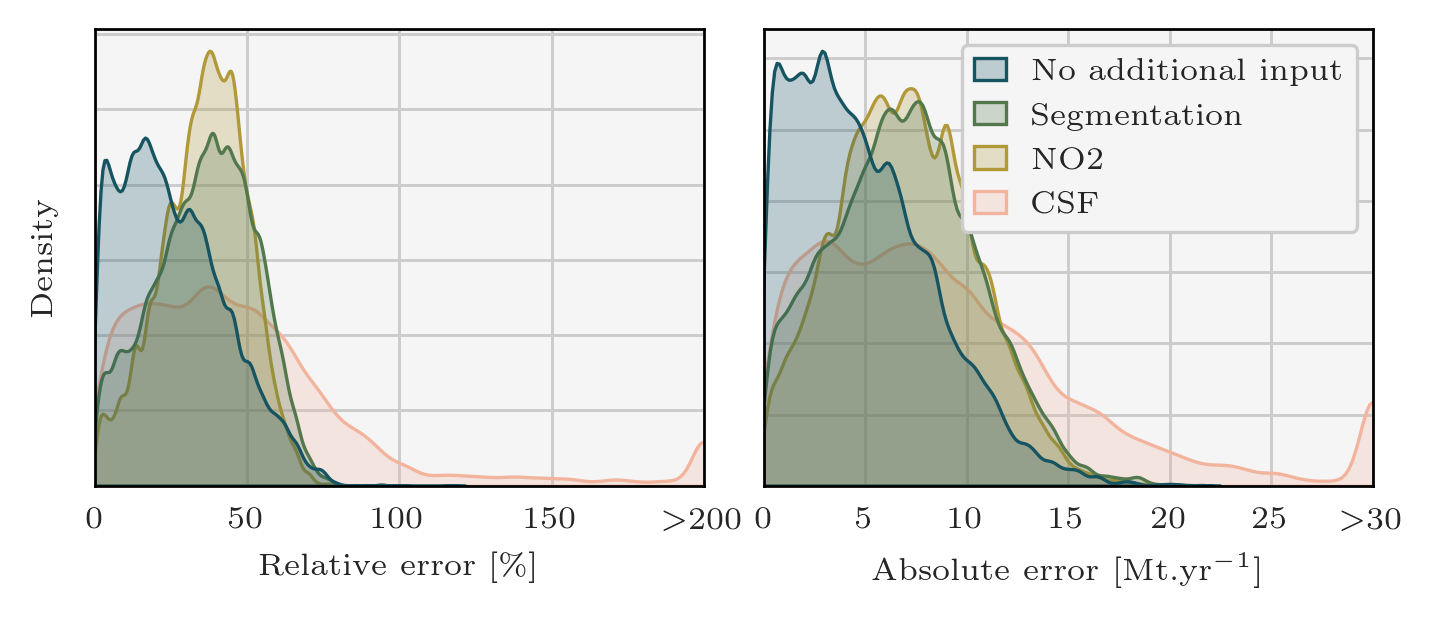

In [183]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    all_df_box["df_mape"],
    x="Absolute relative error (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)
axs[i_ax].set_xlabel("Relative error [$\%$]")
axs[i_ax].set_xticks([0, 50, 100, 150, 200])
axs[i_ax].set_xticklabels(["0", "50", "100", "150", "$>$200"])

i_ax = 1
sns.kdeplot(
    all_df_box["df_mae"],
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)
axs[i_ax].set_xlabel("Absolute error [Mt.yr$^{-1}$]")
axs[i_ax].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[i_ax].set_xticklabels(["0", "5", "10", "15", "20", "25", "$>$30"])

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"box_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

### Residuals

In [111]:
box_none_diff = np.squeeze(res_box_none["pred"]) - np.squeeze(
    res_box_none["data"].y.eval
)
box_seg_pred_no2_diff = np.squeeze(res_box_seg_pred_no2["pred"]) - np.squeeze(
    res_box_seg_pred_no2["data"].y.eval
)
box_no2_diff = np.squeeze(res_box_no2["pred"]) - np.squeeze(res_box_no2["data"].y.eval)

df_box_diff = pd.DataFrame(
    {
        "No add. input": box_none_diff,
        "Segmentation": box_seg_pred_no2_diff,
        "NO2": box_no2_diff,
    }
)

paper-inv/tur_perf.pdf


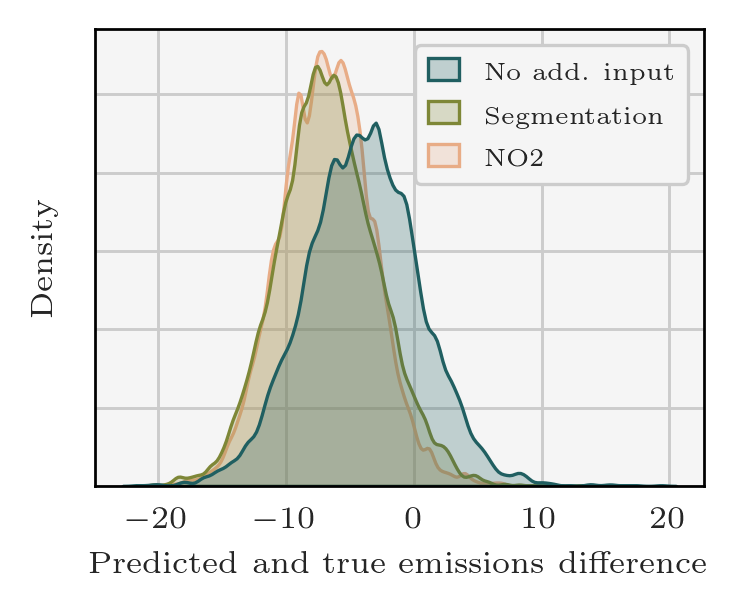

In [112]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)


sns.kdeplot(
    df_box_diff,
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[0],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)

plt.xlabel("Predicted and true emissions difference")
axs[0].set_yticklabels([])
axs[0].grid(linewidth=0.7, alpha=1)
legend = plt.gca().get_legend()
for text in legend.texts:
    text.set_fontsize(6)

# name_fig = os.path.join(dir_plots, f"box_residuals.pdf")
# plt.savefig(name_fig, dpi=300)
print(name_fig)

### no2+plume_scaling

In [33]:
dir_res_exp_scaling = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34"
)
all_dir_box_scaling = []
for root, dirs, files in os.walk(dir_res_exp_scaling):
    if "w_best.h5" in files:
        all_dir_box_scaling.append(root)

In [34]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box_scaling:
    cfg = OmegaConf.load(os.path.join(dir_res_exp_scaling, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [73]:
res_box_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/9
MAE 6.600532 6.439148
MAPE 33.902527 34.869637
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/8
MAE 6.7019963 6.499091
MAPE 34.490757 35.365086
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/6
MAE 7.372822 7.2222176
MAPE 37.78282 39.180164
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/7
MAE 6.810372 6.673704
MAPE 35.104824 36.370934
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/10
MAE 5.055502 4.5821857
MAPE 26.115509 25.193192
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/11
MAE 5.83893

### seg_pred_no2+plume_scaling

In [74]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box_scaling:
    cfg = OmegaConf.load(os.path.join(dir_res_exp_scaling, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [75]:
res_box_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/12
MAE 6.124698 5.9243307
MAPE 32.18798 31.57105
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/13
MAE 6.3533974 6.131384
MAPE 33.497154 33.59712
197/197 [==============================] - 1s 5ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/15
MAE 6.318605 6.104947
MAPE 33.259804 33.207275
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/14
MAE 5.588103 5.2474604
MAPE 29.440962 28.788975
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/16
MAE 5.161963 4.6462154
MAPE 27.55925 25.19409
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/res/inversion/inv_box_025_34/17
MAE 5.2838

# Turow

In [38]:
path_eval_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"
path_valid_tur = "/libre/dumontj/coco2/dl-input/2km_forTur_2/valid_dataset.nc"
dir_res_tur = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur"

In [39]:
all_dir_tur = []
for root, dirs, files in os.walk(dir_res_tur):
    if "w_best.h5" in files:
        all_dir_tur.append(root)

### None

In [40]:
chan_3 = "None"
all_dirs_tur_none = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_none.append(dir)

In [41]:
res_tur_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_none, path_eval_tur
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_none
MAE 2.6544998 2.1629772
MAPE 31.395502 25.570274
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/6
MAE 2.9918563 2.4186425
MAPE 35.673603 28.455418
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/5
MAE 2.9785478 2.3531265
MAPE 35.60566 28.26637
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/8
MAE 2.8413188 2.346065
MAPE 33.840874 28.346031
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/7
MAE 2.7574039 2.2408285
MAPE 32.937897 27.080864

Ensemble
MAE 2.705183 2.2023401
MAPE 32.3153 26.63972


### no2

In [42]:
chan_3 = "no2"
all_dirs_tur_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_no2.append(dir)

In [43]:
res_tur_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_no2, path_eval_tur
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2
MAE 2.3264184 1.906291
MAPE 27.25837 22.711815
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/16
MAE 2.3966227 1.9410124
MAPE 28.301374 23.027401
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/17
MAE 2.45881 1.9779305
MAPE 29.124563 23.118675
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/18
MAE 2.4494064 1.9952521
MAPE 28.887642 23.54814
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/19
MAE 2.4598076 2.0235744
MAPE 28.979498 23.859213

Ensemble
MAE 2.3188393 1.8965607
MAPE 27.36432 22.060236


### seg_pred_no2

In [44]:
chan_3 = "seg_pred_no2"
all_dirs_tur_seg_pred_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_seg_pred_no2.append(dir)

In [45]:
res_tur_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_tur_seg_pred_no2, path_eval_tur
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/2
MAE 2.7390285 2.2110715
MAPE 32.60082 25.831163
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/1
MAE 2.9028375 2.3763142
MAPE 34.32119 27.993372
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_seg_pred_no2
MAE 2.5787847 2.0613232
MAPE 31.12513 23.850103
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/3
MAE 3.102903 2.490842
MAPE 37.90949 28.79697
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/4
MAE 2.824427 2.219174
MAPE 33.708683 26.1776

Ensemble
MAE 2.6101074 2.09369
MAPE 31.407455 24.421112


### cross-sectional

In [46]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Tur", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [133]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_tur_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_tur_cs["mae"]), np.median(metrics_tur_cs["mae"]))
print("mape:", np.mean(metrics_tur_cs["mape"]), np.median(metrics_tur_cs["mape"]))

images analysed: 0.9949117506757831
mae: 8.17825064643822 4.471558506868509
mape: 97.83589002098984 52.12086537159644


## Performance histograms

In [281]:
res_tur_none = model_eval.add_raw_inv_metrics(res_tur_none)
res_tur_seg_pred_no2 = model_eval.add_raw_inv_metrics(res_tur_seg_pred_no2)
res_tur_no2 = model_eval.add_raw_inv_metrics(res_tur_no2)

In [290]:
metrics = {
    "none": res_tur_none["metrics"],
    "seg_pred_no2": res_tur_seg_pred_no2["metrics"],
    "no2": res_tur_no2["metrics"],
    "cs": metrics_tur_cs,
}
all_df_tur = model_eval.build_df_perf_inv(metrics)
result_latex = all_df_tur["res"].rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

In [178]:
print(result_latex.to_latex())

\begin{tabular}{lrrrlrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{APE} & \multicolumn{3}{l}{AE} & \multicolumn{3}{l}{Relative error (\%)} & \multicolumn{3}{l}{Raw difference (Mt/yr)} \\
{} &  25\% &  50\% & \multicolumn{2}{l}{75\%} & 25\% & 50\% & 75\% &                25\% &  50\% & 75\% &                    25\% & 50\% &  75\% \\
Add. input:         &      &      &      &   &     &     &     &                    &      &     &                        &     &      \\
\midrule
No additional input & 12.3 & 26.6 & 43.6 &   & 1.0 & 2.2 & 3.8 &               -1.9 &  0.2 & 2.6 &                    5.4 & 7.8 & 10.5 \\
Segmentation        & 11.1 & 24.4 & 43.0 &   & 1.0 & 2.1 & 3.7 &               -1.1 &  0.9 & 3.1 &                    6.3 & 8.5 & 10.9 \\
NO2                 & 10.9 & 22.1 & 37.1 &   & 0.9 & 1.9 & 3.2 &               -2.0 & -0.3 & 1.7 &                    5.4 & 7.3 &  9.6 \\
CSF                 & 26.3 & 52.1 & 92.0 &   & 2.2 & 4.5 & 8.1 &               -3.5 &  0.4 & 6.9 &        

/tmp/ipykernel_278872/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/tur_perf.pdf


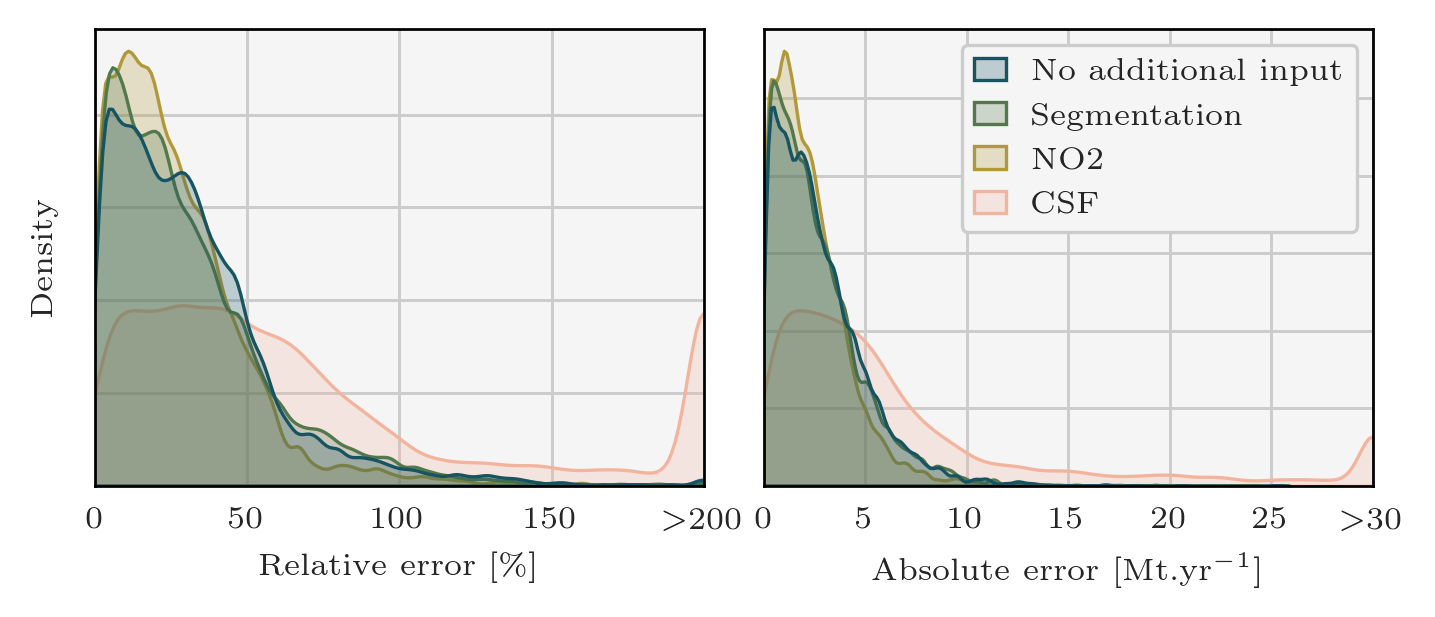

In [181]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    all_df_tur["df_mape"],
    x="Absolute relative error (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 200)
axs[i_ax].set_xlabel("Relative error [$\%$]")
axs[i_ax].set_xticks([0, 50, 100, 150, 200])
axs[i_ax].set_xticklabels(["0", "50", "100", "150", "$>$200"])

i_ax = 1
sns.kdeplot(
    all_df_tur["df_mae"],
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)
axs[i_ax].set_xlabel("Absolute error [Mt.yr$^{-1}$]")
axs[i_ax].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[i_ax].set_xticklabels(["0", "5", "10", "15", "20", "25", "$>$30"])

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"tur_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# KDE Lip - Tur - Box

paper-inv/all_perf.pdf


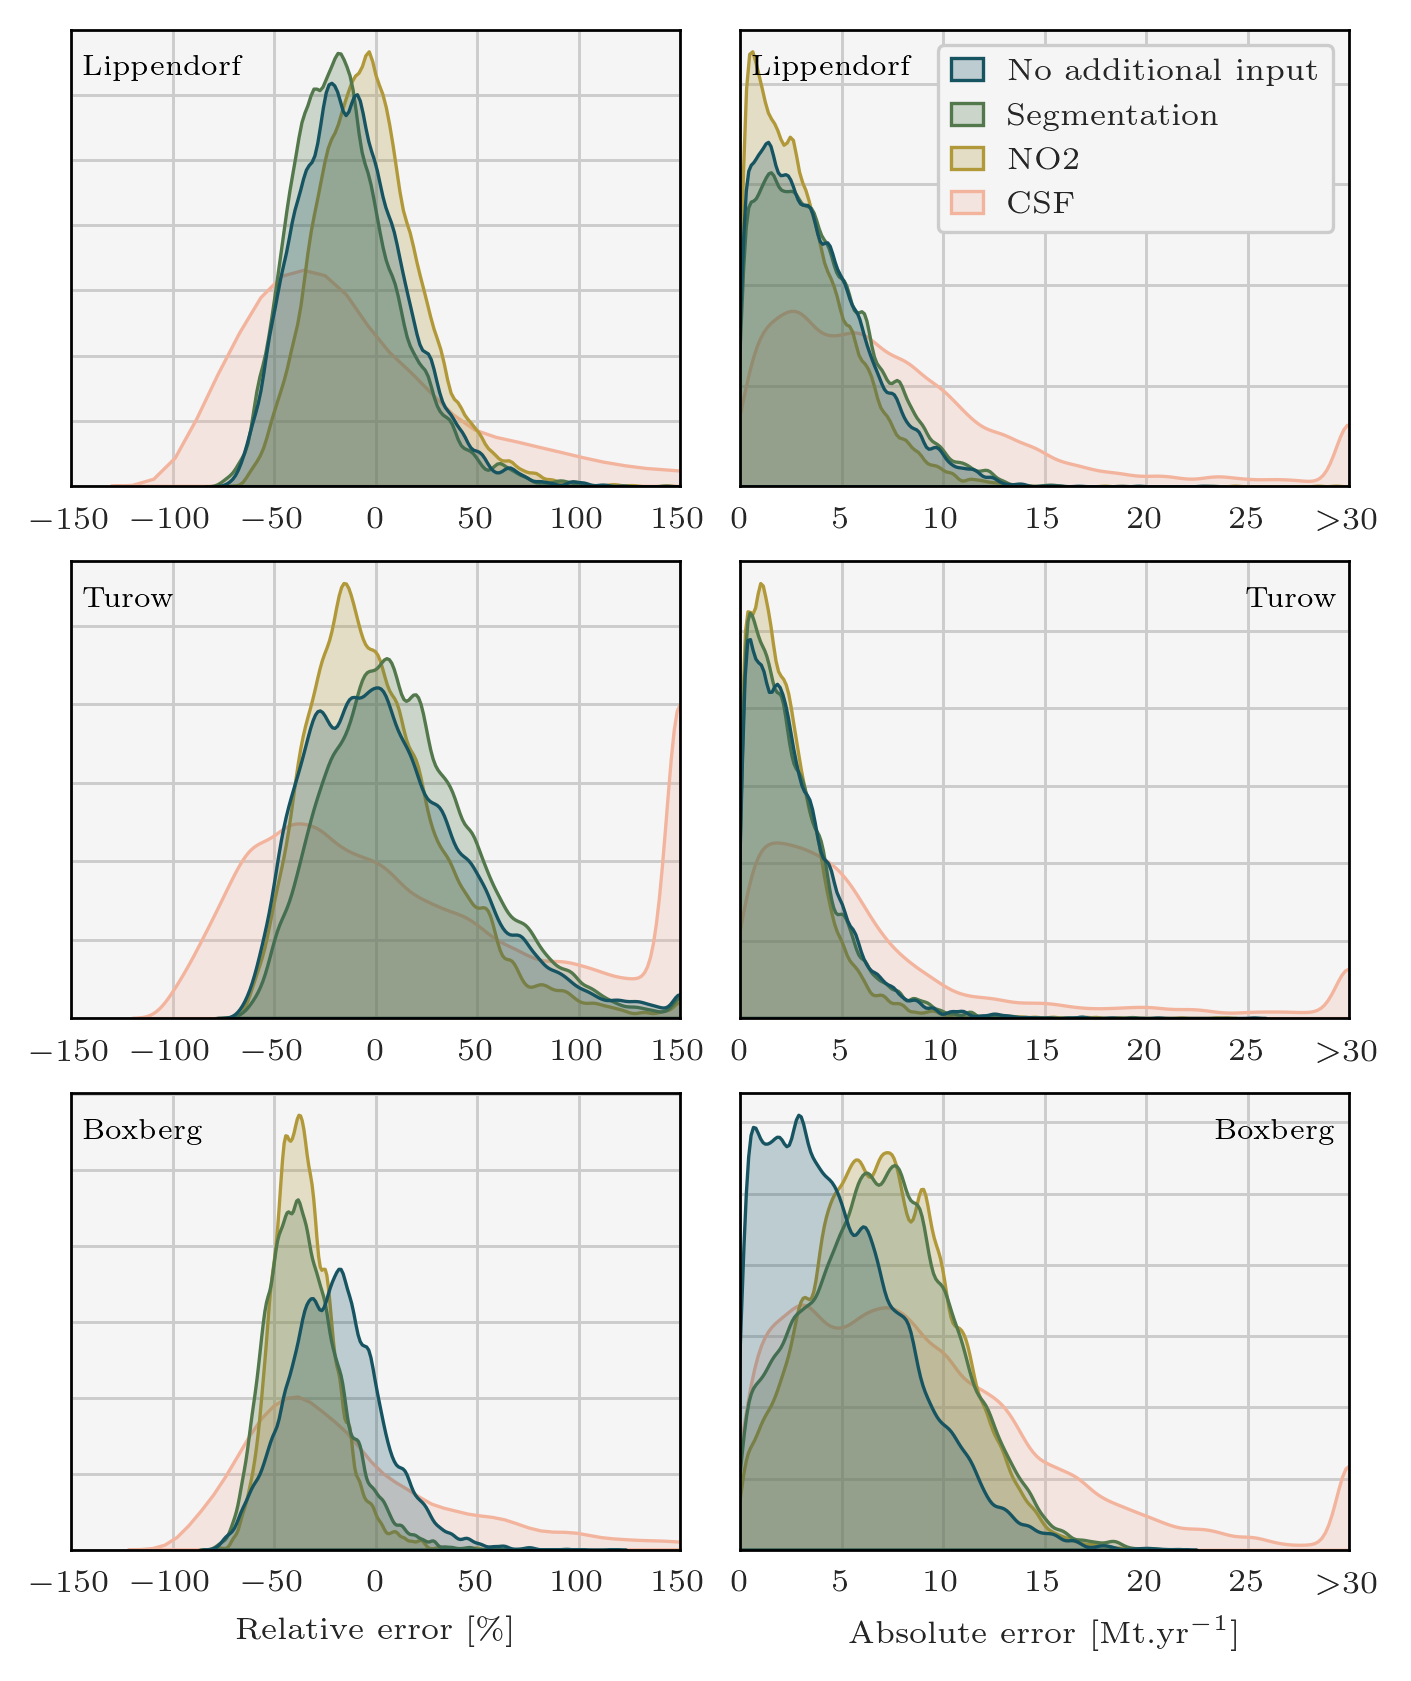

In [309]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    3,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

for i_row, all_df in zip(range(3), [all_df_lip, all_df_tur, all_df_box]):
    i_ax = int(i_row * 2)
    sns.kdeplot(
        all_df["df_rel"],
        x="Relative error (%)",
        hue="Add. input:",
        common_norm=False,
        fill=True,
        lw=0.8,
        alpha=0.25,
        levels=1,
        bw_adjust=0.5,
        ax=axs[i_ax],
        palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
    )
    axs[i_ax].set_xlim(-150, 150)
    axs[i_ax].set_xlabel("Relative error [$\%$]")
    # axs[i_ax].set_xticks([0, 50, 100, 150, 200])
    # axs[i_ax].set_xticklabels(["0", "50", "100", "150", "$>$200"])

    i_ax = int(i_row * 2 + 1)
    sns.kdeplot(
        all_df["df_mae"],
        x="Absolute error (Mt/yr)",
        hue="Add. input:",
        common_norm=False,
        fill=True,
        lw=0.8,
        alpha=0.25,
        levels=1,
        bw_adjust=0.5,
        ax=axs[i_ax],
        palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
    )
    axs[i_ax].set_xlim(0, 30)
    axs[i_ax].set_xlabel("Absolute error [Mt.yr$^{-1}$]")
    axs[i_ax].set_xticks([0, 5, 10, 15, 20, 25, 30])
    axs[i_ax].set_xticklabels(["0", "5", "10", "15", "20", "25", "$>$30"])

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
    ax.set_ylabel("")
for ax in axs[:4]:
    # ax.set_xticklabels([])
    ax.set_xlabel("")
for ax in [axs[0]] + list(axs[2:]):
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)

titles = ["Lippendorf", "Lippendorf", "Turow", "Turow", "Boxberg", "Boxberg"]
for i, title in enumerate(titles):
    if i in [0, 1, 2, 4]:
        axs[i].annotate(
            title,
            fontsize=7,
            xycoords="axes fraction",
            xy=(0.02, 0.9),
            color="black",
            fontname="Serif",
        )
    if i in [3]:
        axs[i].annotate(
            title,
            fontsize=7,
            xycoords="axes fraction",
            xy=(0.83, 0.9),
            color="black",
            fontname="Serif",
        )

    if i in [5]:
        axs[i].annotate(
            title,
            fontsize=7,
            xycoords="axes fraction",
            xy=(0.78, 0.9),
            color="black",
            fontname="Serif",
        )


name_fig = os.path.join(dir_plots, f"all_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Lippendorf NO2 experience

In [91]:
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/best_no2"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"

In [92]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_eval_nc,
)

model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_best.h5"
)

In [93]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

197/197 [==============================] - 1s 5ms/step
mae: 3.181809 2.6199703
mape: 21.941608 17.712584


In [94]:
no2 = data.ds.no2.values
plume = data.ds.no2_plume.values
scaled_no2 = no2 - plume + 1.5 * plume
data.x.eval[:, :, :, -1] = scaled_no2 + np.random.randn(*scaled_no2.shape) * scaled_no2
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

197/197 [==============================] - 1s 5ms/step
mae: 3.33003 2.8335867
mape: 22.010944 19.047955


In [95]:
N = 50
all_mape = np.zeros(shape=(N))
scalings = np.linspace(0, 3, N)
for idx, scaling in enumerate(scalings):
    scaled_no2 = no2 - plume + scaling * plume
    data.x.eval[:, :, :, -1] = (
        scaled_no2 + np.random.randn(*scaled_no2.shape) * scaled_no2
    )
    metrics = model_eval.get_inv_metrics_model_on_data(model, data)
    all_mape[idx] = np.median(metrics["mape"])

197/197 [==============================] - 1s 4ms/step


paper-inv/lip_no2_exp.pdf


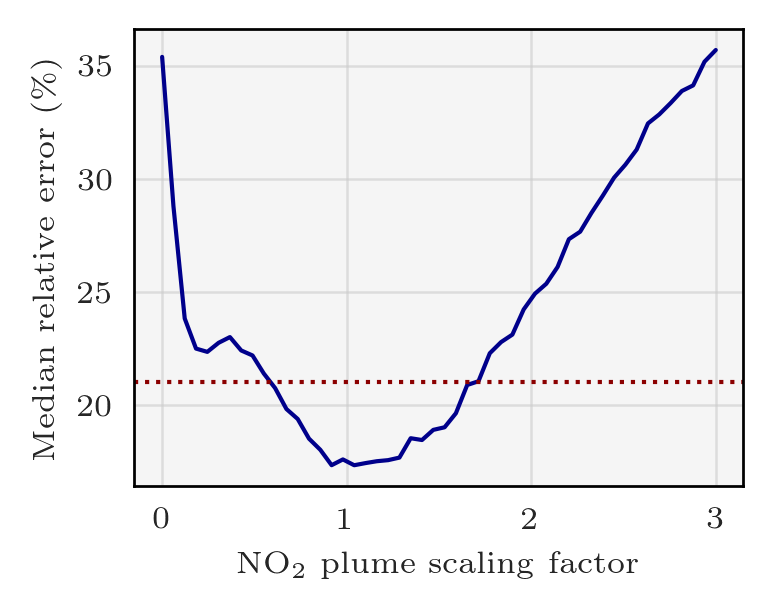

In [96]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.4,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

sns.lineplot(
    x=scalings,
    y=all_mape,
    color="darkblue",
    markersize=3,
    linewidth=1,
    ax=axs[0],
)

plt.axhline(21, color="darkred", linestyle=":", linewidth=1)

plt.xlabel("NO$_2$ plume scaling factor")
plt.ylabel("Median relative error ($\%$)")

name_fig = os.path.join(dir_plots, f"lip_no2_exp.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Boxberg learning curves

In [3]:
df = pd.read_csv("paper-inv/wandb_loss/wandb_losses_3.csv")

In [9]:
def drop_equal_columns(df):
    equal_cols = set()
    num_cols = df.shape[1]

    for i in range(num_cols - 1):
        col1 = df.iloc[:, i]

        for j in range(i + 1, num_cols):
            col2 = df.iloc[:, j]

            if col1.equals(col2):
                equal_cols.add(df.columns[j])

    df = df.drop(equal_cols, axis=1)
    return df


# Drop the columns with equal values
equal_cols = df.columns[df.nunique() == 1]

df = drop_equal_columns(df)

# Fill NA of half of columns with previous value
column_names = [
    "random_None - val_mean_absolute_percentage_error",
    "random_seg - val_mean_absolute_percentage_error",
    "random_no2 - val_mean_absolute_percentage_error",
]
for column_name in column_names:
    df[column_name] = df[column_name].fillna(method="ffill", limit=1)

# Drop NA rows and and change column names
df = df.dropna()
df = df.drop("Step", axis=1)
new_column_names = {
    "random_None - extra_val_metric_0": "None - Test",
    "random_seg - extra_val_metric_0": "Segmentation - Test",
    "random_no2 - extra_val_metric_0": "NO2 - Test",
    "random_None - val_mean_absolute_percentage_error": "None - Valid",
    "random_seg - val_mean_absolute_percentage_error": "Segmentation - Valid",
    "random_no2 - val_mean_absolute_percentage_error": "NO2 - Valid",
}
df = df.rename(columns=new_column_names)
df.index = range(1000)

# Smooth columns
from scipy.ndimage import gaussian_filter1d

sigma = 10
smoothed_df = df.apply(lambda col: gaussian_filter1d(col, sigma))

desired_order = [
    "None - Valid",
    "Segmentation - Valid",
    "NO2 - Valid",
    "None - Test",
    "Segmentation - Test",
    "NO2 - Test",
]

# Reorder the columns
df = df.reindex(columns=desired_order)

In [10]:
df.iloc[-1]

None - Valid           34.4
Segmentation - Valid   31.2
NO2 - Valid            26.2
None - Test            23.9
Segmentation - Test    31.8
NO2 - Test             36.3
Name: 999, dtype: float64

paper-inv/box_losses.pdf


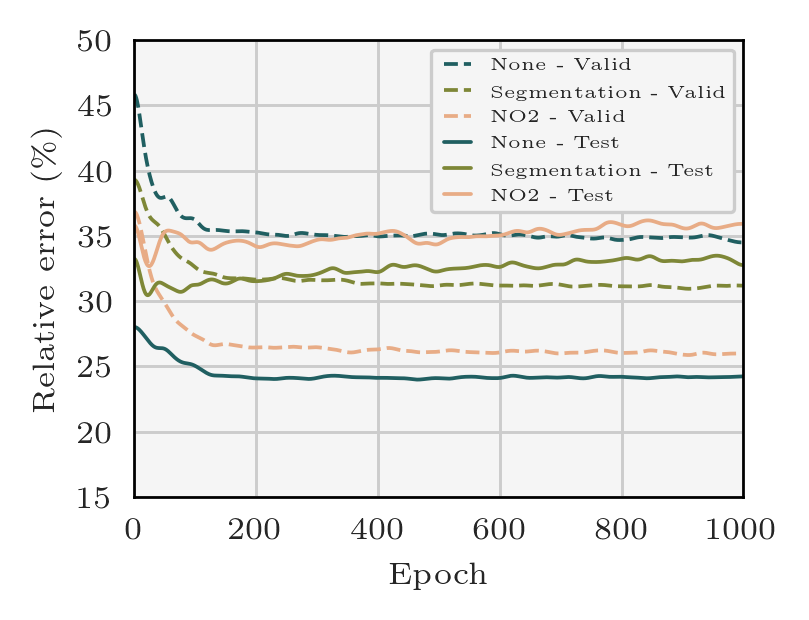

In [99]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.35,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

colors = sns.color_palette("cmc.batlowW", int(len(df.columns) / 2))
colors = colors + colors
line_styles = ["dashed", "dashed", "dashed", "-", "-", "-"]

# Plot each column with specified color and line style

for col, color, ls in zip(df.columns, colors, line_styles):
    sns.lineplot(
        data=smoothed_df[col],
        color=color,
        linestyle=ls,
        label=col,
        ax=axs[0],
        linewidth=0.9,
        markers=True,
    )

plt.xlabel("Epoch")
plt.ylabel("Relative error ($\%$)")
plt.ylim(15, 50)
axs[0].grid(linewidth=0.7, alpha=1)
plt.xlim(0, 1000)


plt.legend(loc=1, prop={"size": 4.5}, handlelength=2)

name_fig = os.path.join(dir_plots, f"box_losses.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Boxberg reduced ds

In [45]:
path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_box = "/libre/dumontj/coco2/dl-input/2km_forBox_4/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "box_reduced_ds")

In [46]:
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)

### None

In [47]:
chan_3 = "None"
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)

In [55]:
res_box_rds_none = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_none, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/best_none
MAE 4.3315063 3.6537151
MAPE 22.90018 20.303492
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/26
MAE 4.959063 4.2726517
MAPE 26.538641 23.243437
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/27
MAE 4.394525 3.6866174
MAPE 23.471573 20.096106
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/28
MAE 4.509593 3.8181705
MAPE 24.167597 20.775248
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/29
MAE 4.4830823 3.8071232
MAPE 23.751019 20.918762
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/24
MAE 4.7579827 4.0883474
MAPE 25.

### no2

In [49]:
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [56]:
res_box_rds_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/12
MAE 5.3834963 5.116768
MAPE 27.829489 27.627954
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/21
MAE 5.8113594 5.466671
MAPE 29.655577 30.395567
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/best_no2
MAE 4.1111765 3.6065655
MAPE 21.574654 19.71693
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/20
MAE 4.109032 3.6515274
MAPE 21.558126 19.526255
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/19
MAE 5.052253 4.636407
MAPE 26.20278 25.474072
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/17
MAE 5.4548516 5.2340984
MAPE 28.1742

### seg_pred_no2

In [51]:
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)

In [57]:
res_box_rds_seg_pred_no2 = model_eval.get_inv_metrics_pred_from_ensemble_paths(
    all_dirs_box_seg_pred_no2, path_eval_box
)

197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/10
MAE 5.275475 4.673499
MAPE 27.81218 25.722439
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/11
MAE 5.3254333 4.7699366
MAPE 28.213863 26.372252
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/7
MAE 5.7207937 5.2902317
MAPE 30.101917 29.040981
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/8
MAE 5.4259796 4.933261
MAPE 28.583797 27.256504
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/9
MAE 5.153932 4.6454716
MAPE 26.673746 25.791883
197/197 [==============================] - 1s 4ms/step
/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/6
MAE 5.4397125 4.9514494
MAPE 28.776022 26.95

### cross-sectional

In [59]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Box", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [61]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_box_rds_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_box_rds_cs["mae"]), np.median(metrics_box_rds_cs["mae"]))
print(
    "mape:", np.mean(metrics_box_rds_cs["mape"]), np.median(metrics_box_rds_cs["mape"])
)

metrics_box_cs = metrics_cs

images analysed: 0.8495786293528383
mae: 9.727348490085312 7.730007449884406
mape: 52.86260729526279 41.52475536655409


## Performance histograms

In [62]:
res_box_rds_none = model_eval.add_raw_inv_metrics(res_box_rds_none)
res_box_rds_seg_pred_no2 = model_eval.add_raw_inv_metrics(res_box_rds_seg_pred_no2)
res_box_rds_no2 = model_eval.add_raw_inv_metrics(res_box_rds_no2)

In [65]:
metrics = {
    "none": res_box_rds_none["metrics"],
    "seg_pred_no2": res_box_rds_seg_pred_no2["metrics"],
    "no2": res_box_rds_no2["metrics"],
    "cs": metrics_box_rds_cs,
}
all_df_box_rds = model_eval.build_df_perf_inv(metrics)
result_latex = all_df_box_rds["res"].rename(columns={result.iloc[:, 0].name[0]: "APE"})
result_latex = result_latex.rename(columns={result.iloc[:, 4].name[0]: "AE"})
result_latex.insert(3, "", "")

NameError: name 'result' is not defined

In [112]:
print(result_latex.to_latex())

\begin{tabular}{lrrrlrrr}
\toprule
{} & \multicolumn{4}{l}{APE} & \multicolumn{3}{l}{AE} \\
{} &  25\% &  50\% & \multicolumn{2}{l}{75\%} & 25\% & 50\% &  75\% \\
Add. input:         &      &      &      &   &     &     &      \\
\midrule
No additional input &  9.5 & 20.4 & 33.8 &   & 1.8 & 3.7 &  6.3 \\
Segmentation        & 14.1 & 26.6 & 40.6 &   & 2.5 & 4.8 &  7.6 \\
NO2                 & 13.2 & 23.8 & 34.2 &   & 2.3 & 4.4 &  6.6 \\
CSF                 & 21.7 & 41.5 & 63.5 &   & 3.9 & 7.7 & 12.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_31294/1320843946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_latex.to_latex())


paper-inv/box_reduced_ds_perf.pdf


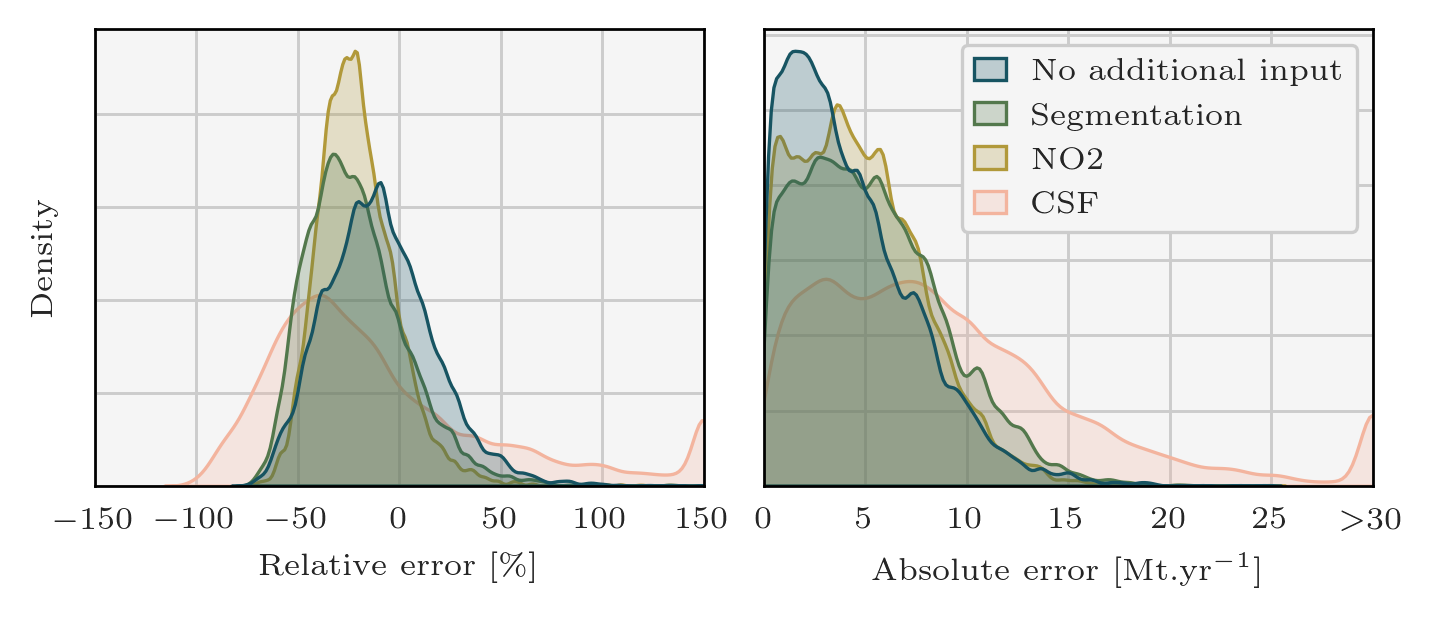

In [69]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    1,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

i_ax = 0
sns.kdeplot(
    all_df_box_rds["df_rel"],
    x="Relative error (%)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(-150, 150)
axs[i_ax].set_xlabel("Relative error [$\%$]")

i_ax = 1
sns.kdeplot(
    all_df_box_rds["df_mae"],
    x="Absolute error (Mt/yr)",
    hue="Add. input:",
    common_norm=False,
    fill=True,
    lw=0.8,
    alpha=0.25,
    levels=1,
    bw_adjust=0.5,
    ax=axs[i_ax],
    palette="cmc.batlowW",  # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
)
axs[i_ax].set_xlim(0, 30)
axs[i_ax].set_xlabel("Absolute error [Mt.yr$^{-1}$]")
axs[i_ax].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[i_ax].set_xticklabels(["0", "5", "10", "15", "20", "25", "$>$30"])

for ax in axs:
    ax.grid(linewidth=0.7, alpha=1)
    ax.set_yticklabels([])
for ax in [axs[0]]:
    ax.get_legend().remove()
for ax in [axs[1]]:
    ax.legend_.set_title(None)
    ax.set_ylabel("")

name_fig = os.path.join(dir_plots, f"box_reduced_ds_perf.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Gradient based methods

In [114]:
name_model_lip_none = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/best_none"
)
path_eval_nc_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"

name_model_box_none = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/weights/box_reduced_ds/best_none"
)
path_eval_nc_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"

name_model_tur_none = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_none"
name_model_tur_no2 = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2"
path_eval_nc_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"

In [115]:
tf.random.set_seed(10)
np.random.seed(10)

In [116]:
data_lip_none = model_eval.get_data_for_inversion(
    name_model_lip_none,
    path_eval_nc_lip,
)
plume_lip_none = np.expand_dims(data_lip_none.ds.plume.values, -1)
model_lip_none = model_eval.get_inversion_model(name_model_lip_none, name_w="w_last.h5")

data_box_none = model_eval.get_data_for_inversion(
    name_model_box_none,
    path_eval_nc_box,
)
plume_box_none = np.expand_dims(data_box_none.ds.plume.values, -1)
model_box_none = model_eval.get_inversion_model(name_model_box_none, name_w="w_last.h5")

data_tur_none = model_eval.get_data_for_inversion(
    name_model_tur_none,
    path_eval_nc_tur,
)
plume_tur_none = np.expand_dims(data_tur_none.ds.plume.values, -1)
model_tur_none = model_eval.get_inversion_model(name_model_tur_none, name_w="w_last.h5")

data_tur_no2 = model_eval.get_data_for_inversion(
    name_model_tur_no2,
    path_eval_nc_tur,
)
plume_tur_no2 = np.expand_dims(data_tur_no2.ds.plume.values, -1)
model_tur_no2 = model_eval.get_inversion_model(name_model_tur_no2, name_w="w_last.h5")

In [117]:
idx0 = np.random.choice(data_lip_none.ds.attrs["N_img"])
idx0 = 3575
x = tf.cast(data_lip_none.x.eval[idx0 : idx0 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_lip_none.x.eval[idx0 : idx0 + 1], tf.float32)
)
integ_grad_lip_none = model_eval.integrated_gradients(
    model_lip_none, x, baseline_tensor
)

In [118]:
idx1 = np.random.choice(data_box_none.ds.attrs["N_img"])
idx1 = 5168
x = tf.cast(data_box_none.x.eval[idx1 : idx1 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_box_none.x.eval[idx1 : idx1 + 1], tf.float32)
)
integ_grad_box_none = model_eval.integrated_gradients(
    model_box_none, x, baseline_tensor
)

In [119]:
idx2 = np.random.choice(data_tur_none.ds.attrs["N_img"])
idx2 = 4978
x = tf.cast(data_tur_none.x.eval[idx2 : idx2 + 1], tf.float32)
baseline_tensor = tf.zeros_like(
    tf.cast(data_tur_none.x.eval[idx2 : idx2 + 1], tf.float32)
)
integ_grad_tur_none = model_eval.integrated_gradients(
    model_tur_none, x, baseline_tensor
)

In [120]:
idx3 = np.random.choice(data_tur_no2.ds.attrs["N_img"])
idx3 = idx2  # 963, 1860,766, 4978, 5523
baseline_tensor = tf.zeros_like(
    tf.cast(data_tur_no2.x.eval[idx3 : idx3 + 1], tf.float32)
)
x = tf.cast(data_tur_no2.x.eval[idx3 : idx3 + 1], tf.float32)
integ_grad_tur_no2 = model_eval.integrated_gradients(model_tur_no2, x, baseline_tensor)

In [121]:
list_idx = [idx0, idx1, idx2, idx3]
list_data = [data_lip_none, data_box_none, data_tur_none, data_tur_no2]
list_plume = [plume_lip_none, plume_box_none, plume_tur_none, plume_tur_no2]
list_integ_grad = [
    integ_grad_lip_none,
    integ_grad_box_none,
    integ_grad_tur_none,
    integ_grad_tur_no2,
]
list_sources = ["Lippendorf", "Boxberg", "Turow", "Turow (NO2)"]

paper-inv/integ_gradients.pdf


<Figure size 1200x900 with 0 Axes>

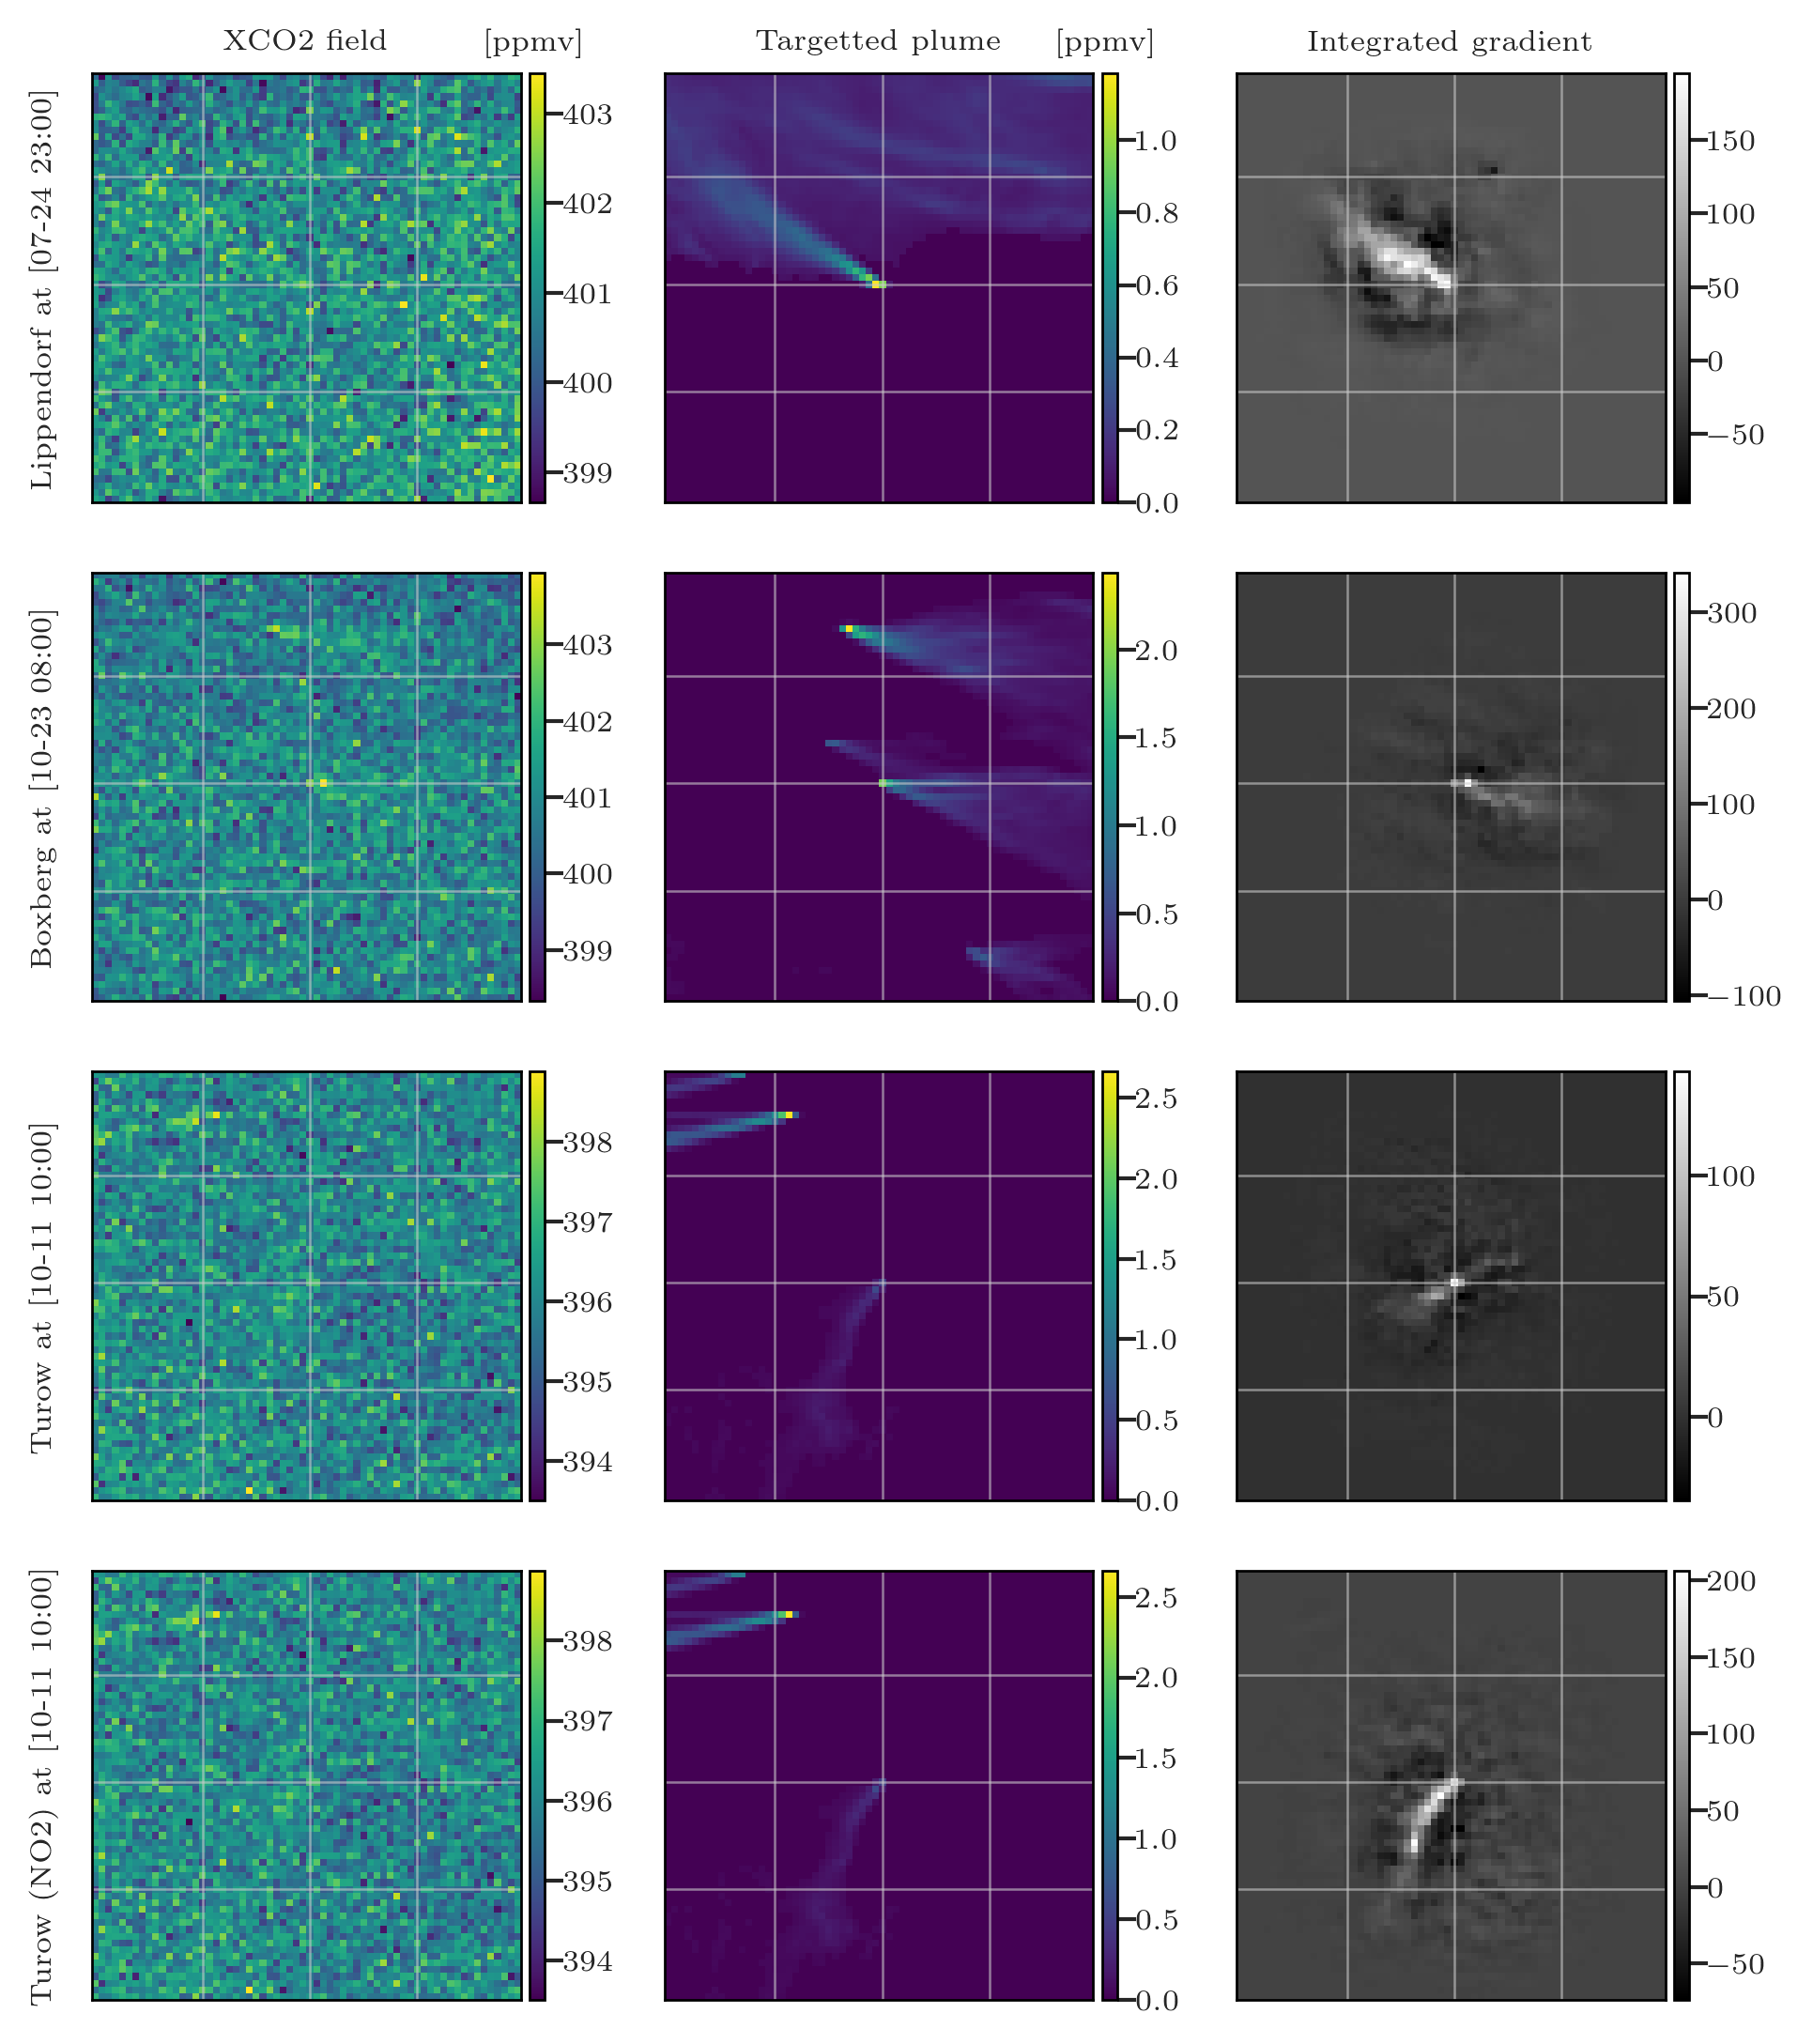

In [122]:
N_idx = 4
N_cols = 3
mympf.setMatplotlibParam(target="paper")
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data_tur_none.x.eval.shape[1])
Nx = int(data_tur_none.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i, (idx, data, plume, integ_grad) in enumerate(
    zip(list_idx, list_data, list_plume, list_integ_grad)
):

    cur_row = 0

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(plume[idx, :, :, 0]), origin="lower")
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = cur_row + i * N_cols
    cur_row += 1
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(integ_grad.numpy()[:, :, 0]), cmap="gray", origin="lower"
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

list_pd_t = []
for (idx, data) in zip(list_idx, list_data):
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, (pd_t_idx, source) in enumerate(zip(list_pd_t, list_sources)):
    axs[i * N_cols].set_ylabel(
        f"{source} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Integrated gradient")

cbars[0].ax.set_title("[ppmv]")
cbars[1].ax.set_title("[ppmv]")

name_fig = os.path.join(dir_plots, f"integ_gradients.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

# Feature permutation importance

In [123]:
all_dir_lip = []
for root, dirs, files in os.walk(dir_res_lip):
    if "w_best.h5" in files:
        all_dir_lip.append(root)

chan_3 = "None"
all_dirs_lip_none = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_none.append(dir)

chan_3 = "seg_pred_no2"
all_dirs_lip_seg_pred_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_seg_pred_no2.append(dir)

chan_3 = "no2"
all_dirs_lip_no2 = []
for dir in all_dir_lip:
    cfg = OmegaConf.load(os.path.join(dir_res_lip, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_lip_no2.append(dir)

In [124]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
importance_lip = {}
importance_lip["none"] = [0, 0, 0]
for dir in all_dirs_lip_none:
    importance_lip["none"] = importance_lip[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["none"] = importance_lip["none"] / len(all_dirs_lip_none)
importance_lip["none"] = np.insert(importance_lip["none"], 3, np.nan)

importance_lip["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_lip_seg_pred_no2:
    importance_lip["seg_pred_no2"] = importance_lip[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["seg_pred_no2"] = importance_lip["seg_pred_no2"] / len(
    all_dirs_lip_seg_pred_no2
)

importance_lip["no2"] = [0, 0, 0, 0]
for dir in all_dirs_lip_no2:
    importance_lip["no2"] = importance_lip[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_lip)
importance_lip["no2"] = importance_lip["no2"] / len(all_dirs_lip_no2)

baseline 29.836779
perm (0,) permuted_loss 45.12252
perm (1,) permuted_loss 39.488716
perm (2,) permuted_loss 33.751472
baseline 33.127995
perm (0,) permuted_loss 46.59262
perm (1,) permuted_loss 41.439865
perm (2,) permuted_loss 37.313198
baseline 26.11288
perm (0,) permuted_loss 46.795208
perm (1,) permuted_loss 39.6296
perm (2,) permuted_loss 32.10714
baseline 25.796535
perm (0,) permuted_loss 46.392395
perm (1,) permuted_loss 38.92393
perm (2,) permuted_loss 31.322681
baseline 23.723526
perm (0,) permuted_loss 43.037617
perm (1,) permuted_loss 35.96264
perm (2,) permuted_loss 28.853962
baseline 25.215895
perm (0,) permuted_loss 44.712444
perm (1,) permuted_loss 38.06087
perm (2,) permuted_loss 29.82287
baseline 24.447618
perm (0,) permuted_loss 43.549675
perm (1,) permuted_loss 36.803078
perm (2,) permuted_loss 28.86166
baseline 28.915506
perm (0,) permuted_loss 56.611195
perm (1,) permuted_loss 38.184376
perm (2,) permuted_loss 33.01941
perm (3,) permuted_loss 53.591396
baseline 2

In [125]:
all_dir_tur = []
for root, dirs, files in os.walk(dir_res_tur):
    if "w_best.h5" in files:
        all_dir_tur.append(root)

chan_3 = "None"
all_dirs_tur_none = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_none.append(dir)

chan_3 = "seg_pred_no2"
all_dirs_tur_seg_pred_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_seg_pred_no2.append(dir)

chan_3 = "no2"
all_dirs_tur_no2 = []
for dir in all_dir_tur:
    cfg = OmegaConf.load(os.path.join(dir_res_tur, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_tur_no2.append(dir)

In [126]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_tur = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"
importance_tur = {}
importance_tur["none"] = [0, 0, 0]
for dir in all_dirs_tur_none:
    importance_tur["none"] = importance_tur[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["none"] = importance_tur["none"] / len(all_dirs_tur_none)
importance_tur["none"] = np.insert(importance_tur["none"], 3, np.nan)

importance_tur["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_tur_seg_pred_no2:
    importance_tur["seg_pred_no2"] = importance_tur[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["seg_pred_no2"] = importance_tur["seg_pred_no2"] / len(
    all_dirs_tur_seg_pred_no2
)

importance_tur["no2"] = [0, 0, 0, 0]
for dir in all_dirs_tur_no2:
    importance_tur["no2"] = importance_tur[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_tur)
importance_tur["no2"] = importance_tur["no2"] / len(all_dirs_tur_no2)

baseline 30.953062
perm (0,) permuted_loss 40.66159
perm (1,) permuted_loss 35.761772
perm (2,) permuted_loss 32.628754
baseline 35.833294
perm (0,) permuted_loss 48.284424
perm (1,) permuted_loss 42.551403
perm (2,) permuted_loss 39.445744
baseline 35.64139
perm (0,) permuted_loss 49.291397
perm (1,) permuted_loss 42.454037
perm (2,) permuted_loss 39.185963
baseline 33.99446
perm (0,) permuted_loss 48.26613
perm (1,) permuted_loss 40.045357
perm (2,) permuted_loss 37.969715
baseline 33.19865
perm (0,) permuted_loss 46.04646
perm (1,) permuted_loss 40.42364
perm (2,) permuted_loss 37.119278
baseline 31.272852
perm (0,) permuted_loss 46.550465
perm (1,) permuted_loss 39.114025
perm (2,) permuted_loss 33.527233
perm (3,) permuted_loss 44.1198
baseline 33.132725
perm (0,) permuted_loss 46.861233
perm (1,) permuted_loss 40.59786
perm (2,) permuted_loss 36.34166
perm (3,) permuted_loss 45.71425
baseline 30.418354
perm (0,) permuted_loss 35.465366
perm (1,) permuted_loss 33.06046
perm (2,) p

In [127]:
dir_res_box = os.path.join(dir_res, "box/reduced_ds")
all_dir_box = []
for root, dirs, files in os.walk(dir_res_box):
    if "w_best.h5" in files:
        all_dir_box.append(root)
chan_3 = "None"
all_dirs_box_none = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_none.append(dir)
chan_3 = "seg_pred_no2"
all_dirs_box_seg_pred_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_seg_pred_no2.append(dir)
chan_3 = "no2"
all_dirs_box_no2 = []
for dir in all_dir_box:
    cfg = OmegaConf.load(os.path.join(dir_res_box, dir, "config.yaml"))
    if cfg["data"]["input"]["chan_3"] == chan_3:
        all_dirs_box_no2.append(dir)

In [128]:
tf.random.set_seed(10)
np.random.seed(10)

path_eval_box = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
importance_box = {}
importance_box["none"] = [0, 0, 0]
for dir in all_dirs_box_none:
    importance_box["none"] = importance_box[
        "none"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["none"] = importance_box["none"] / len(all_dirs_box_none)
importance_box["none"] = np.insert(importance_box["none"], 3, np.nan)

importance_box["seg_pred_no2"] = [0, 0, 0, 0]
for dir in all_dirs_box_seg_pred_no2:
    importance_box["seg_pred_no2"] = importance_box[
        "seg_pred_no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["seg_pred_no2"] = importance_box["seg_pred_no2"] / len(
    all_dirs_box_seg_pred_no2
)

importance_box["no2"] = [0, 0, 0, 0]
for dir in all_dirs_box_no2:
    importance_box["no2"] = importance_box[
        "no2"
    ] + model_eval.channel_permutation_importance(dir, path_eval_box)
importance_box["no2"] = importance_box["no2"] / len(all_dirs_box_no2)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
importances = np.zeros((4, 3 * 3))

In [ ]:
importances[:, 0] = importance_lip["none"]
importances[:, 1] = importance_lip["seg_pred_no2"]
importances[:, 2] = importance_lip["no2"]

importances[:, 3] = importance_box["none"]
importances[:, 4] = importance_box["seg_pred_no2"]
importances[:, 5] = importance_box["no2"]

importances[:, 6] = importance_tur["none"]
importances[:, 7] = importance_tur["seg_pred_no2"]
importances[:, 8] = importance_tur["no2"]

In [ ]:
header = pd.MultiIndex.from_product(
    [["Lippendorf", "Boxberg", "Turow"], ["None", "Segmentation", "NO2"]],
    names=["PP", "Add. input"],
)
df = pd.DataFrame(
    importances, index=["XCO2", "u-wind", "v-wind", "Additional input"], columns=header
)
df.insert(loc=3, column="", value="")
df.insert(loc=7, column=" ", value="")
df

In [ ]:
print(df.to_latex())

In [ ]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "best_seg_pred_no2"), path_eval_tur, size_max_combi=2
)

In [ ]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "1"), path_eval_tur, size_max_combi=2
)

In [ ]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "2"), path_eval_tur, size_max_combi=2
)

In [ ]:
model_eval.channel_permutation_importance(
    os.path.join(dir_res_tur, "3"), path_eval_tur, size_max_combi=2
)

# Time series results

In [3]:
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
name_model_lip_none = (
    "/cerea_raid/users/dumontj/dev/coco2/dl/weights/lip/mae_lip/best_none"
)
path_eval_nc_lip = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"

In [5]:
res = model_eval.get_pred_y_from_paths(name_model_lip_none, path_eval_nc_lip)

2023-09-26 15:46:40.756649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:46:41.327572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14708 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-09-26 15:46:42.985038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-26 15:46:43.583608: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 3s 5ms/step


In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

In [7]:
pred = res["pred"].numpy().flatten()
y = res["y"].numpy().flatten()

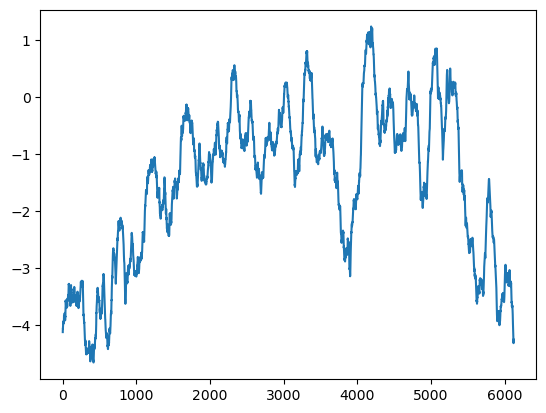

In [40]:
sns.lineplot(moving_average(pred - y, n=7 * 24))
plt.show()

In [42]:
path_ds = os.path.join("/libre/dumontj/coco2/ddeq/eval", "2km_Lip", "cs_emiss_pred.nc")
ds = xr.open_dataset(path_ds)

In [43]:
pred = np.where(ds.cs_emiss_pred.values == -1, np.nan, ds.cs_emiss_pred.values)
idx_notnan = ~np.isnan(pred)
pred = pred[idx_notnan]
pred = np.expand_dims(pred, 1)
y = ds.emiss.values[idx_notnan, 0]
# y = np.concatenate((ds.emiss.values[0:1], ds.emiss.values[0:-1]))
y = np.expand_dims(y, 1)
print("images analysed:", np.sum(idx_notnan) / ds.attrs["N_img"])

metrics_cs = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics_cs["mae"]), np.median(metrics_cs["mae"]))
print("mape:", np.mean(metrics_cs["mape"]), np.median(metrics_cs["mape"]))
metrics_lip_cs = metrics_cs

images analysed: 0.9435522340594689
mae: 9.45554687078409 6.280673210008902
mape: 64.55498100584066 42.813141021105075


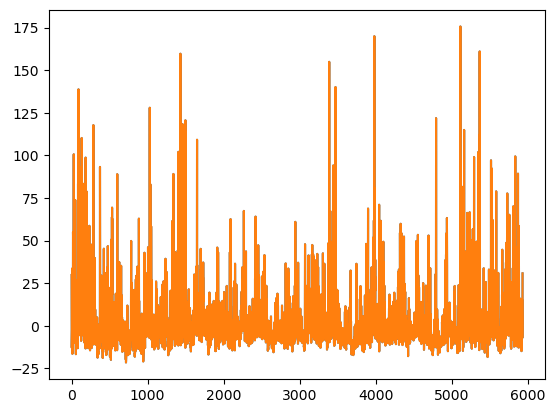

In [45]:
plt.plot(pred - y)
plt.show()

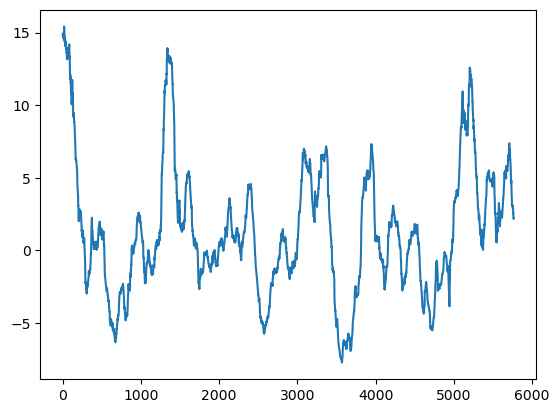

In [46]:
sns.lineplot(moving_average(pred - y, n=7 * 24))
plt.show()

# Map all PP loc

In [11]:
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl/nb_eval")

In [12]:
sys.path.append("/cerea_raid/users/dumontj/dev/coco2/data_build")
import coco2_data_config
import ddeq
import utils
import matplotlib_functions

matplotlib_functions.setMatplotlibParam()
plt.viridis()
from icecream import ic

<Figure size 1920x1440 with 0 Axes>

In [13]:
dir_raw_smartcarb_xco2_data = os.path.join(
    coco2_data_config.raw_data_dir, "smartcarb", "cosmo2D"
)


names_sources = [
    "Berlin",
    "Boxberg",
    "Janschwalde",
    "Lippendorf",
    "Turow",
    "Patnow",
    "Schwarze Pumpe",
    "Dolna Odra",
    "Opole",
]

sources = ddeq.misc.read_point_sources()
sc_coord = utils.get_raw_smartcarb_grid_coords()

In [171]:
year = 2015
month = np.random.choice(np.arange(1, 13))
day = np.random.choice(np.arange(1, 32))
hour = np.random.choice(np.arange(1, 24))

In [172]:
ic(month, day, hour)

ic| month: 4, day: 30, hour: 14


(4, 30, 14)

In [173]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Globally set text and label sizes
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [174]:
cosmo_2d_file = os.path.join(
    dir_raw_smartcarb_xco2_data, f"cosmo_2d_{year:01}{month:02}{day:02}{hour:02}.nc"
)

ds = xr.open_dataset(
    cosmo_2d_file,
    decode_times=False,
)

XCO2_plume = ds.XCO2_BV.values[0] + ds.XCO2_JV.values[0] + ds.XCO2_A.values[0]
XCO2_bg = ds.XCO2_BG.values[0] + ds.XCO2_RA.values[0]

paper-inv/PP_locations.pdf


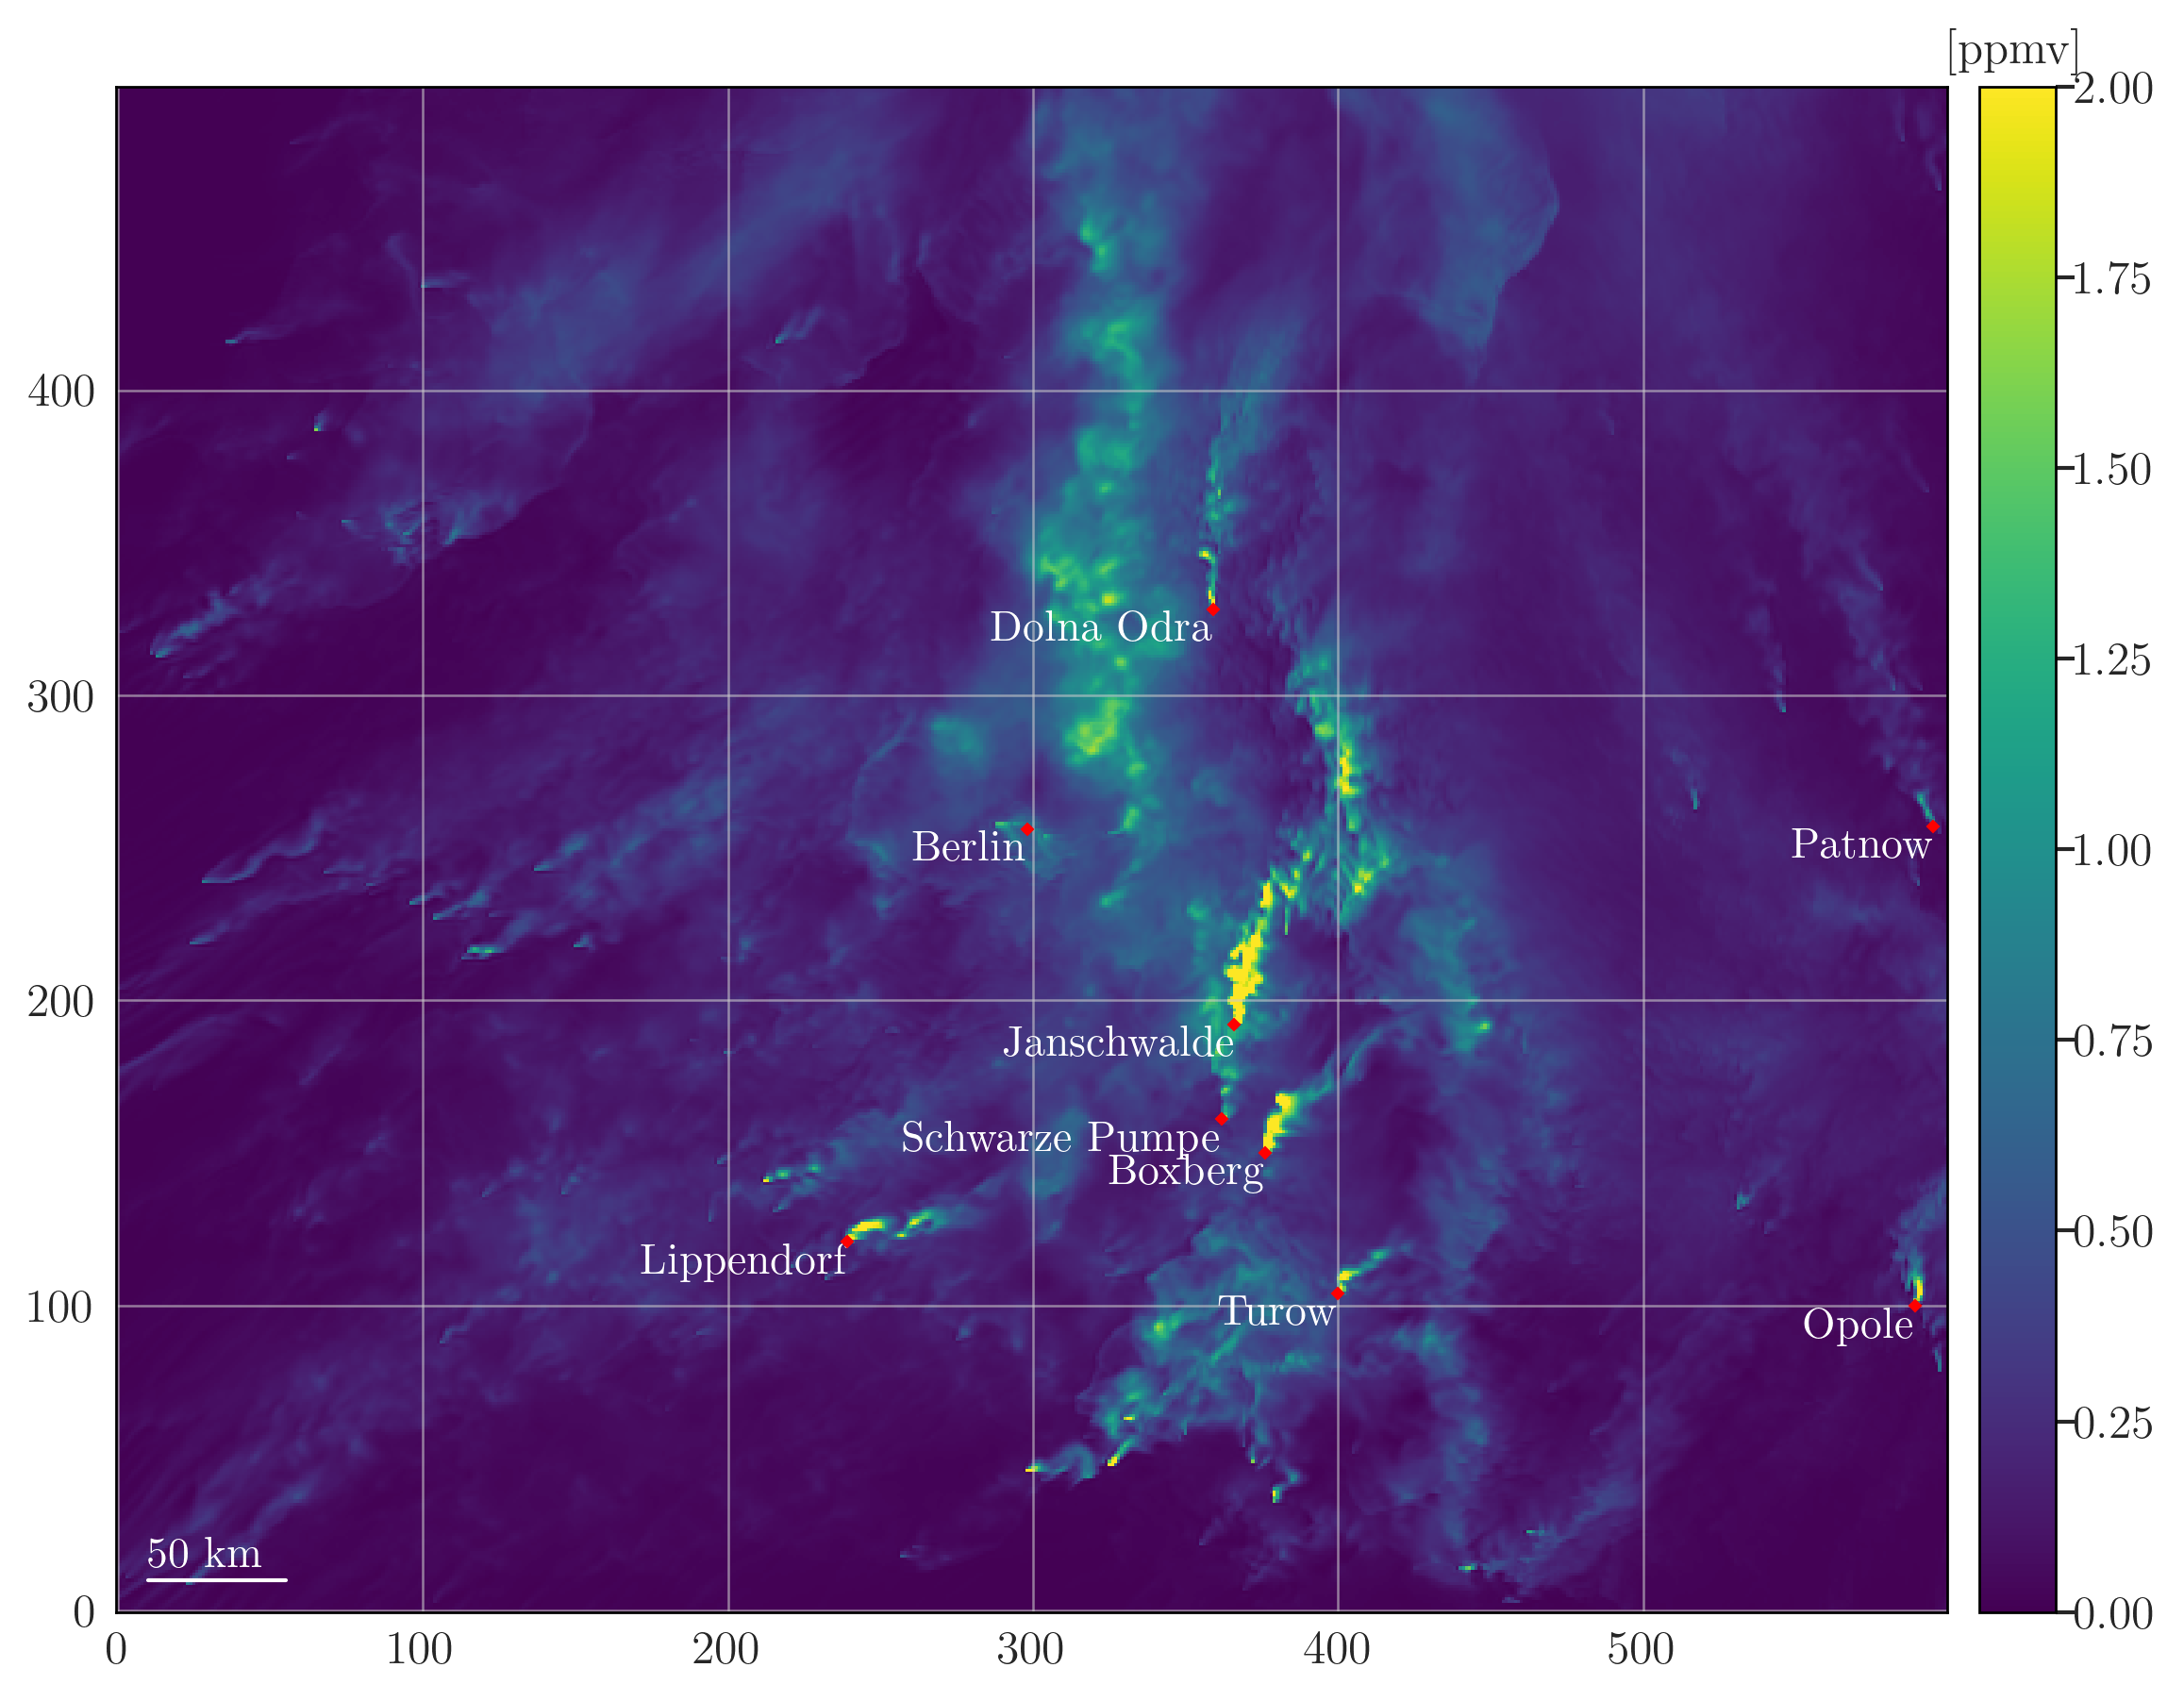

In [175]:
vmax = 1
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
contour = plt.imshow(XCO2_plume[50:-50, 50:-50], vmin=0, vmax=2, origin="lower")
cbar = fig.colorbar(contour, ax=ax, pad=0.01)
cbar.ax.set_title("[ppmv]", fontsize=12)

for name_source in names_sources:
    source_coords = utils.get_sc_source_coords(name_source)
    source_grid_point = utils.get_closest_grid_point_indices(sc_coord, source_coords)
    ax.plot(
        source_grid_point["x"] - 50,
        source_grid_point["y"] - 50,
        "D",
        markersize=2,
        color="red",
        label="_none_",
        zorder=10,
    )
    ax.annotate(
        name_source,
        xy=(source_grid_point["x"] - 50, source_grid_point["y"] - 50),
        xytext=(0, -8),  # specify the offset in points
        textcoords="offset points",
        horizontalalignment="right",
        color="white",
        fontsize=11,
    )
scale_bar_length = 45  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [10, 10 + scale_bar_length],
    [10, 10],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(10, 14, f"50 km", color=scale_bar_color, fontsize=11)

name_fig = os.path.join(dir_plots, f"PP_locations.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

In [177]:
date = (4, 30, 14)

# Emission rates

In [8]:
path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Lip", "train_valid_dataset.nc"
)
ds_lip = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Ber", "train_valid_dataset.nc"
)
ds_ber = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Jan", "train_valid_dataset.nc"
)
ds_jan = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Box", "train_valid_dataset.nc"
)
ds_box = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Tur", "train_valid_dataset.nc"
)
ds_tur = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Pat", "train_valid_dataset.nc"
)
ds_pat = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Opo", "train_valid_dataset.nc"
)
ds_opo = xr.open_dataset(path_ds)

path_ds = os.path.join(
    "/libre/dumontj/coco2/dl-input", "2km_Dolo", "train_valid_dataset.nc"
)
ds_dolo = xr.open_dataset(path_ds)

In [10]:
mympf.setMatplotlibParam(target="paper")
axs = mympf.set_figure_axs(
    4,
    2,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.35,
    pad_w_ext_right=0.2,
    pad_w_int=0.25,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

sns.lineplot(ds_lip.emiss[:, 0].values, ax=axs[0])
sns.lineplot(ds_ber.emiss[:, 0].values, ax=axs[1])
sns.lineplot(ds_box.emiss[:, 0].values, ax=axs[2])
sns.lineplot(ds_opo.emiss[:, 0].values, ax=axs[3])
sns.lineplot(ds_dolo.emiss[:, 0].values, ax=axs[4])
sns.lineplot(ds_tur.emiss[:, 0].values, ax=axs[5])
sns.lineplot(ds_pat.emiss[:, 0].values, ax=axs[6])
sns.lineplot(ds_jan.emiss[:, 0].values, ax=axs[7])


for ax in axs[:6]:
    ax.set_xticklabels([])
    ax.set_xlabel("")


for ax in [axs[0], axs[2], axs[4], axs[6]]:
    ax.set_ylabel("Emission rate in Mt/yr")

for ax in [axs[6], axs[7]]:
    ax.set_xlabel("Image index")

titles = [
    "Lippendorf",
    "Berlin",
    "Boxberg",
    "Opole",
    "Dolna Odra",
    "Turow",
    "Patnow",
    "Janschwalde",
]
for i, title in enumerate(titles):
    axs[i].annotate(
        title,
        fontsize=7,
        xycoords="axes fraction",
        xy=(0.4, 0.9),
        color="black",
        fontname="Serif",
    )
name_fig = os.path.join(dir_plots, f"emission_rates_sources.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)

paper-inv/emission_rates_sources.pdf
